# WGAN Training for DataChallenge

In [1]:
import os
import sys
import yaml
import argparse
sys.path.append('../../')

import torch
import pytorch_lightning as pl
import numpy as np
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning import Trainer, loggers
from syndatagenerators.data_preparation.datachallenge import lcl_to_hdf5, load_households_from_hdf, DataChallengeDataModule
from syndatagenerators.data_preparation.datasets import PowerDataModule

from syndatagenerators.models.wgan.wgan_baseline_model import BaselineWGAN, Generator, Critic
from syndatagenerators.models.utils.callbacks import MMDCallback, ACFCallback, DiscriminativeCallback
from syndatagenerators.models.utils.plot_functions import plot_sample_grid

from syndatagenerators.metrics.mmd_score import mmd
import matplotlib.pyplot as plt

In [2]:
# path to configuration file
CONFIG_PATH = '../models/utils/config_wgan.yml'
config = yaml.safe_load(open(CONFIG_PATH, 'r'))
train_params = config['train_params']
config

{'train_params': {'batch_size': 128,
  'lr_gen': 1e-05,
  'lr_dis': 1e-05,
  'epochs': 500,
  'lambda_gp': 10.0,
  'n_critic': 5,
  'name': 1,
  'input_shape': [1, 96],
  'latent_dim': 100,
  'optimizer': 'RMSProp',
  'nb_labels': 1},
 'dis_params': {'kernel_size': 3, 'channel_dim': 32},
 'gen_params': {'kernel_size': 3, 'channel_dim': 32},
 'data_params': {'ckpt_dir': '/share/data1/bschaefermeier/chkpt/wgan/'}}

In [3]:
parser = argparse.ArgumentParser(description='wgan Baseline')
parser.add_argument('--batch_size', type=int, default=train_params['batch_size'], help='input batch size for training')
parser.add_argument('--epochs', type=int, default=train_params['epochs'], help='number of epochs to train')
parser.add_argument('--name', type=int, default=train_params['name'], help='name under which model is saved')
parser.add_argument('--input_shape', type=tuple, default=tuple(train_params['input_shape']), help='input shape of training samples (i.e. tu'
                                                                      'ple of feature dims and seq len')
parser.add_argument('--latent_dim', type=int, default=train_params['latent_dim'], help='dimension of latent noise vector')
parser.add_argument('--kernel_size_dis', type=int, default=config['dis_params']['kernel_size'], help='length of kernel in conv blocks of'
                                                                   ' discriminator')
parser.add_argument('--kernel_size_gen', type=int, default=config['gen_params']['kernel_size'], help='length of kernel in conv blocks of generator')
parser.add_argument('--channel_nb_dis', type=int, default=config['dis_params']['channel_dim'], help='channel dim in discriminator')
parser.add_argument('--channel_nb_gen', type=int, default=config['gen_params']['channel_dim'])
parser.add_argument('--lr_dis', type=float, default=train_params['lr_dis'], help='learning rate of discriminator')
parser.add_argument('--lr_gen', type=float, default=train_params['lr_gen'], help='learning rate of generator')
parser.add_argument('--lambda_gp', type=float, default=train_params['lambda_gp'], help='penalty term parameter')
parser.add_argument('--optimizer', type=str, default=train_params['optimizer'], help='optimizer used in training')
parser.add_argument('--n_critic', type=int, default=train_params['n_critic'], help='number of training iterations of critic w.r.t.'
                                                            ' generator')

args = parser.parse_args([])

In [ ]:
# TODO: remove 4eeb1554-fcbf-423c-937d-01e88d423196 if not done yet.

In [4]:
# Reload OpenMeter but only the households which will be used for training (Privat, removing one outlier household with extremely high power consumption)
households_to_use_list = ['22d3fd2c-a23d-4620-899a-1faee6da511c', '28769f0b-7601-4e5e-823f-97f8ef469910', 'e016926c-fa5c-49a7-a715-6b30d4aab4ed', '18025781-5a6c-4489-a850-7ba0f76eaadc', '8a579476-1069-4087-9ac2-12f728a6cc66', 'e58f2df6-778c-44d8-9c51-1deb5afd99a5', '6b253309-89b7-4282-a2f6-337284356dab', '5c8fbb63-735e-44ec-8f2f-0e0d99aadbfd', '2ed46eeb-bb38-4bd4-b16b-85db6f9f4267', 'cce1b7bc-4290-4312-8534-db7bc2b23a8f', '24595c1e-dd40-4c2e-b2d0-f8499ea7bd7b', '376c1716-47cd-4972-ad72-5ff9bd0e96c1', '8fabd8cb-1261-464b-a0c7-84b948bba530', 'b68504d5-b0d7-44af-a129-745dcc7f4345', 'fa90c793-cba7-4cb7-baad-3b0d8358fa87', '2241a124-0e4c-4b18-abb0-0e31108c543b', 'b06afddc-157f-4acb-a3c0-dabd217e47a9', '7558ee98-7e2c-443c-90af-fc0e7e247ef5', 'cec3d5cc-0548-43b4-9d62-772cae2f6034', '7aaf6ed0-00d8-447b-80ea-ddab8849f36c', 'c6f7ab70-0be6-4531-a65c-1d18e57a9aad', 'b2014e5b-0fce-4bf7-9088-36474df74662', 'b1a70e4d-45a4-449a-8f67-e66c21f12d85', 'd3f8e8c4-32ec-4035-a9b5-ba8c945caa4b', '6b0845f1-fbf6-40fb-9a69-9d104cfa75c6', '248f76e2-0154-466c-a85a-3a3fc22c43fa', '2d873d88-54d9-4a10-92ee-a716cae15a0f', '6e77f347-726a-4b41-a259-c9b55ae723eb', '496f1d46-1cf9-4c2a-96cd-2dc69c66d13a', '6f7d1d04-49af-456b-8f6f-1edf0f8a65f9', 'baacb198-9a92-4826-b1f2-13bb4f922f78', 'b65b40a8-489a-4266-9320-e96d85dd44e0', 'da91589e-a16e-4235-9778-f91d0182a857', '33d8f854-cd3f-41aa-bc22-b6a66a034dd8', '77926d4b-10eb-4e64-8ee4-6458cede1882', '286087f2-254e-430f-950d-b13f92346b7d', '44a6a6ba-5fa6-489d-9c61-139f59788c4c', 'd772f57f-1333-4be7-b43a-200c7dd22b8b', '7205a5fd-6307-493e-bf23-892f3eb3633a', '76ee0e6a-d86e-44a5-bc35-7cb81dc30c82', '52832fa5-6515-4188-950a-8f3d65eebce2', 'c0fcf7f2-f21b-4bdb-8b80-c809a263d7cd', '8e07b268-b0e8-4fc4-b02b-4badd5571957', 'efcf63db-735e-4339-98a2-8c9960c928dc', 'b5605a1a-3ed4-4759-8f3b-ec0164f15747', '347dc5f0-fcc8-4631-bbbf-49dc5e1a7955', 'fd440cb5-d81e-40ee-9819-8395a61c3a35', '9ce5483b-a1fc-41ef-8016-e87847613f44', 'd068fe37-f8a8-4e33-a5c1-c046f96a8af4', '504486d3-8316-47ae-82db-bc31e28e12ba', '0252a8f5-9913-47bb-a70f-c86e5c69f71a', '126327a9-1748-498c-a52d-d333b3879074', '1f2d6239-4aa7-48de-a41b-730399e0d405', '3b42328b-52e3-4027-83b6-13b938c7c2ed', '401ba297-e962-4e75-97c9-7f7f20fb48ca', 'f8e1b12a-268d-4021-8140-0375d4d936be', '0247a559-2660-4434-b204-d8f7ef9da4d4', '8060e043-c622-48b8-a963-ba7fbd4b1e52', '23937e19-e689-4ddc-99dd-bdbed63f3eb7', 'f4ae88f2-4183-4f39-86ff-0b3bfa44211b', 'e0a16fc2-dd90-4015-af33-c1378508f9ed', '6f4ad391-b95c-4ac7-b59f-371c947bcdb5', 'c95842e3-1125-4ad9-9940-0f132773469b', 'f3c1bd43-0076-4c08-9f16-b86200328a52', '1fafc377-6171-4b57-affd-f4cb989c1792', 'a14e7cba-cb2c-4154-9a5c-72b0cb5fb479', '2dc461e9-3a9e-4860-975b-6c88d5204b48', 'ad594dbc-f077-4fd2-9dcd-42b3cbcd2192', '7f18dee7-69f5-4075-8ac3-e530188e3739', 'e83fd0c9-1fc4-4395-b144-36232430bc31', '0520f1fd-30d5-4ffe-8c57-35c36615586c', '718d8e77-f83f-4856-840d-8df0a3d09da8', '946e85d5-1700-4de4-aa43-80d72defebfe', '271a4536-185e-46b1-a407-a37ca78b7dae', '1666d51f-e1b0-4825-9acf-3b312f032483', '54bb3ccc-d1e2-4246-91bb-c2ec61bfe2eb', '9468ecb1-45d4-498d-bcca-e04f27b1dcea', '5de58362-7ebb-40b1-9335-60562b2cdcbb', 'ce281f72-1cb7-4db1-99cc-9c196a7f4e00', 'cecfe8bb-c817-46d2-aa27-008174fe3128', '001dce72-b1c1-44b1-bf16-0c22cfe3a420', 'ddad5aec-cf51-4321-a649-3fa209c1498c', '9ce00f15-6d49-4010-a16a-9416cc542031', '87211969-c89f-4207-8f8e-60c9086dbc7f', '51995fa8-aff1-4efb-a366-bd2e60c2ac18', '6fafd6fb-e139-44f8-9f63-960f607221ca', '50cbb5c5-aba9-434f-8519-7535a7b735ab', '555a243d-7c29-454a-8374-d8e55c1e80d3', '79c4b2a4-8184-48e0-b36e-24146f28e12e', '39627f86-c458-4d90-a520-2f003529f93c', '51b02e2a-3702-4f33-8f8c-cbd06cf79050', 'a49ef75f-c934-447f-bd23-559a6a799a6c', 'e8d5afeb-1ea9-4121-b14f-48f939624c7e', 'a2ab14fc-b563-4e70-bbfe-d64cc9cdade9', '0358067f-cd41-4d91-ba9e-91405fbfc704', 'c21da8e5-e1fa-4b47-9d85-5abd92b48676', '19636f91-d044-4bc4-8cab-d9fae1bd07c0', '7cf6335e-2892-4057-83be-294074cf605b', '904cdf3f-e79b-4b80-8531-79f6343eb70e', '9510637f-edd1-4362-b77a-5e5af2afbd40', 'e8169711-d925-4032-8b84-ab2cebb1bd8c', '220ea888-da70-483a-8e85-ea169bb96638', '30dc5b53-e184-405a-bb21-43a60c7344fb', '4fc5c9de-ad94-4c52-b1b3-329cf6a3f5cc', '0987b42a-c841-4454-90ac-69e5b1054cd5', '6028b036-d45e-4271-b5be-3b2a825f61bb', '66f02100-c3ec-4480-9fba-1b3260129cd6', '96593fda-33be-4d8f-88f7-9a5fc6b8b888', '12aedcfd-33cd-47ac-b495-81c13e0c3039', '0de28587-2941-47f6-9555-b4456ab5ae9c', '6402f9bb-b2ac-47d2-b944-75945fa856e4', '9415ae40-f716-4e78-88b9-51b17fe8acc9', 'baceccf6-99c2-4782-b9d1-691b90968879', '787941a4-d4bf-47bc-8bfc-dd750fe651f3', '9514b930-b41a-4990-8b6d-c0ac4e0b0d67', 'e3a17831-e2af-4002-83a1-57c2aa51f190', '94526bac-11c0-4854-8475-25afcc35dcbd', 'c43336bd-9e0c-46e7-9b27-c712d8ba0a14', '13f73a8c-8876-4d5d-aa85-c7c44c0a960d', '6c2c5ed1-5c20-49c9-9587-0acf85a4ea55', '2f82df5e-78d4-4616-9ab9-5ba69dddabb3', 'da54df98-ffa4-4b1d-9552-40bc0164da8b', '1cc862fc-6e3a-4454-92ac-0649984a9b72', '65a9f0d9-35f1-4fe8-a447-e6f533e9368c', 'c7fd6823-b724-4a5f-9c96-0d9e30133ed4', 'c31919ec-7b31-41f7-a881-8760656f5a78', 'f34846ac-1d2a-457b-ad84-660e7c76fa5d', 'c828b042-f102-4186-b543-ff52fe146342', '6c926838-cd1f-4d5e-a50f-e8ff3f53510d', '8018bb28-1612-461b-afb2-649af8f29a98', '90063fab-7535-459a-b4da-789124247aaf', 'f08a52b7-119f-4797-a306-078abf8f3426', '1714f630-6922-4bfa-84cf-07b61aa076ba', '44d22209-778b-4244-ad0b-f7eecf5d339c', '729c42e9-5169-45ad-a693-58e30038281a', 'de0931c5-afb9-4e52-a745-48dcbc11308f', '7c5ed116-c213-4a50-b330-4d3328ed3e95', '65e70984-7b9d-4e2c-a324-aef5460b202e', 'fe352710-860f-4686-ad4e-e187e99c7256', '9dd60a04-82ff-4979-933b-3f765fdebee3', '5fa47966-1bb1-4f1d-8df1-c31ced754b63', 'bd00a4b7-d6a3-4310-8173-f16e868e96c2', '31bfee98-6de8-4a2b-8896-daf7069f0827', 'c4040dbd-7657-451b-af8a-7e2d35a20982', '6205b6cc-e9ae-4065-8b74-7e0e52e42b49', 'f430e0e4-5cc1-4f40-a5bd-9af423c06677', 'e2304ab3-913c-437e-b363-415361651bb5', 'd4c9f05d-57e0-41b9-b1de-c98942d0c9c8', '9ab2ac51-6547-4a2a-a1ac-02ac4c99883b', 'bca24757-0acc-42fb-a531-a14655da6bd0', 'bd184654-3a4b-4609-b41d-b3b5e55bb1c6', 'e472f992-aad5-4fea-8fa0-e26b6591a323', '4225ef3a-8c23-44a6-a38b-892171d3adcb', 'ef2e3567-bcad-4c28-ac21-9bcbaaf4c385', 'e8eec69f-4ea6-44bc-9ffc-b434575ca38a', '75106228-f23e-4f7b-a3da-9456bb35ea93', '721b47b2-d5cc-411d-80ea-56a2f857acaf', '04b1dc78-587d-4837-978e-ac288a2b480c', 'ccca55e4-25e2-4f2e-a48b-6ca1ec31d96e', 'cd2807e1-0085-4fc6-adfc-6367995d7c34', '3a06e019-2b14-4ed6-9d37-0031640b80a5', '1178737b-13d0-4f18-be37-485975448f37', '319cebc4-74f3-4f4b-b52c-9f6b707a28b3', '9f5a00c2-f4ff-426c-bb2e-921c2bbd21c6', '689006b1-50c6-451a-9e53-89b245dee080', 'b226ba15-8433-4d9d-a3fd-9161439a1b4d', '54e347ca-e41d-427d-ae60-b86443802881', 'e44b6322-1e88-483f-90d3-7e32519b769f', '305f98a7-94fa-413f-a490-1a471d17f547', '8c119331-71a1-4ef2-a5fe-6122e240adef', '9ea84709-259f-4f37-99ee-b8d774894925', 'c24d301f-6475-40e3-b291-43d9cfd88134', '17497f18-6482-4b24-a6d2-02f909d66a37', '21253f10-b379-4846-8891-744b9bad9778', '8cd8c86c-df1c-45b7-85b1-6337d7dcac89', '8aaaad56-171e-4b04-9c6f-5e243d6f3507', '75504b66-0cb8-4235-97f1-6c1591a61260', '84722250-7b20-4b27-b112-db08af7854f6', '5df5fe62-598d-4b46-bb40-ffe9e169d4c4', 'b9d7c4d8-2f13-4f6c-80ca-bbbc9cbd550d', '6b5714fb-56e8-4f68-b05c-b44b8ae7044d', 'bba43084-3a42-4ee1-a261-92b353b24c0a', 'b9bb01f1-e80f-4473-ab13-2455a2eb7ff5', 'fd53424d-2cfa-4a08-8010-98a2b1aec35f', '720a7976-86b1-4a51-95fc-1cb9ba92849d', 'e360e958-e0ce-4c2f-94e2-01e31d151b32', '6a9cb54f-0257-4e2d-9055-1216c51d7a2d', 'cc9122c8-ebdc-4238-a5c3-ec90df8d91bd', '67d6ef4b-f11c-4077-b71e-a3dbb5e91623', 'e7d993b3-fb7d-4fde-bec1-53ac74f24904', '848c4714-27c2-4064-9de8-7a88d60360bc', '0320fee3-66fb-4f70-b139-ff45d4e03a17', '33b6957c-d968-4397-bec1-4ead226b5f68', '63d87914-8afd-4856-90cd-2d00f5d36b4c', 'a5da17fc-3765-4e65-927a-53e54dd2454a', 'a84c293c-80e3-4578-8194-e6eaa290c382', 'b4284ee5-5873-46e8-9593-4c916feaaa34', 'bbf974de-6a5e-4fe9-9873-c54ca3bba75c', '7856246d-8cbf-4bae-bcba-9a734a0637e6', '73f215ea-73cb-41d6-89a7-e2a3eb9b6c16', 'ae540ff8-5f24-48f3-9677-9cc928b6f6c2', '5b8a2d23-6c49-4516-9712-9960c9df651e', 'ef67f92e-0be2-4f7b-9aa0-094149b1e1e4', '37d2353e-8bae-41d2-863e-86adbb8aad5e', '536162d0-a901-4243-947f-bf2dcbef0532', 'bacabe66-e63d-4dee-b350-a85d801c07d7', 'c03cbd32-1df6-4655-b73a-4753ef06fb83', 'e52e65cb-75e9-485d-b294-6fd41c393caf', '03b8c76b-aee3-473e-8f25-c21cea1e0ba6', 'e3eebde2-a143-4434-8a64-061dcab77a54', '4337ad00-30a3-47d9-8f6f-2e7ff6086801', 'fb0d081f-ec23-4e37-aff4-b595e7789b22', '7d50541d-1d50-4ded-8bb4-56c4f2a08ed5', 'f6a5371f-93e9-41f3-81cd-9546ed94055e', '912df36e-fd7c-49bf-a072-40b9b52294d2', '5af6d974-de89-4823-b226-c52cf1104b45', 'fb66b0f7-16cf-4bdc-8099-745f2c6e39e4', 'e060e605-4eda-4cb3-8d72-dd969b94ca5b', '81dc89ea-e932-4e5e-b232-f62f396042eb', '82b052bd-81c7-409e-85a6-a161507cdcaf', 'df64235a-9b4c-4543-a1bf-73bd3e4d8d53', '4241346f-2e6d-4db1-86c2-bf90d8a6af4e', '3f9eccea-aa85-4987-9fa4-ccdc85e92b9e', '60b63962-cc0e-4cea-adcd-6c0308c2cb1c', 'eaa7b605-c2fa-4ff9-9125-3024969db714', '90b04679-6db2-43f3-896c-00049a5eb66d', 'e4628967-a156-4b91-9e2a-593655660359', 'cfa5cfad-50e7-4626-a027-f1b2b1578ea4', 'a9fe09cc-de85-45f9-aa65-077d49a586d2', '8300e048-0fce-4a39-8ac5-e990b22ad9f8', '685740db-827e-4eb5-bd08-5bc8ae905a38', '95f2ef9c-10cb-43fd-a239-d6fe1e4094f3', '96331270-24b9-4577-b509-86187aad3bee', '13afec5f-dd17-4bc5-a544-194ab20575ca', '9be36162-73f3-4981-96fb-cd9e5779784b', 'f6e7f7cd-489a-4536-b48c-a3168df64a1b', 'c24d4d9e-cbbc-4815-8f81-d95911a90f44', 'e06e7a66-c777-4eb9-832f-cb104b34fe25', '8fd50bcc-e036-41ac-ba7b-d9aa870d4f6d', '352f4c93-d38c-4109-a961-03f4db879ec3', 'de068292-41dc-482d-9fd8-92688a7abbb9', '82cec8ed-719f-4352-9b78-ba1ae69560ed', '2ceed31d-5c71-46c8-ba1b-e93a787d683f', '4cbfbd27-821f-4105-bcc9-2c8d62d205c6', '51391be0-c021-471f-8c0a-14a36c8488ad', '12c77d0d-c6a0-4fc8-ae44-022c11e38aa3', 'dbe8794f-2aea-4af7-939c-6dc2cca2e793', '7a906aaf-2609-43d8-bcf5-2c4d73d1d822', 'ce785826-7e58-4582-9b45-048efbe48857', 'c3252268-497a-44ea-b37f-7576de1d8894', 'e866d8ad-8042-499d-aee5-7c5ec420d964', '9b7f9468-a636-4a27-995f-4ab6a18125cd', 'f8964cf8-7f5f-4c4c-b65e-4f1a889ad00c', '5a8082d8-3166-41bd-844b-bfce41bbcd13', '913c7123-048d-44cf-924e-d8e77eb7eaf9', 'c01e315e-6642-417e-9563-357e5d682bc7', 'c4329fb3-632f-4dad-94f6-176e4ea0c7ec', 'c7155c71-4c97-4031-92fc-9e7872fb2f3e', '18ba6fc3-d380-4243-bbef-857c3de97e31', '0d1df061-d516-455b-9194-4b515a2a94af', '7401b884-9ebe-4b11-ad95-9ea729752f49', '476ebd3c-f503-4ff6-9525-7ceddb52010f', '5d303fea-0cbf-4fe4-a638-26644acbdcc4', '367621ef-7d7b-43eb-ba1f-988e90b4fbed', 'ccce5a09-d6a9-428d-af89-41d43d9eb753', 'b9a2746d-9183-4126-a3f8-88df2480784d', 'f872917d-dbbc-4b88-bbf9-ef412a91decc', 'da798658-93b2-4247-8b23-66ef0eb46bb6', '340d6050-bd32-474e-94ed-33b7bf4c1df3', '5a5ae6dd-24bb-46e8-8971-a581b6f8975e', 'ad68fc76-36bb-4318-9b7a-ca1eb7843370', '32cb5e56-6f0b-4e70-be36-db410c823620', '41e334b9-b076-47de-ac59-fb4270b06dd3', '8504cd6e-4113-441a-81e7-14dbcf239a50', '72d8a014-3432-48e7-b086-ddaa8b0e2e74', 'bd1e8fb4-6433-4a03-80ad-1c42db9240ed', '0ab2b2e6-1a39-46c5-bc67-0a635875e03b', 'ec55484f-d199-4c01-b45e-218424e32894', 'd8d942fe-e6bb-42cb-96ca-a6c9e37d148e', '41a4575e-db00-4ed4-b77d-df2d628f46c1', 'e5a00a12-9321-41ea-bbc5-4665578ec279', 'bc83dddd-68dc-41d8-8e73-acd7c05bba8c', 'c2d07729-1c8f-4859-aece-965790c914b6', '04b810f1-7117-4dd3-8fc1-1845877daf63', '9742cee9-4f6c-4f14-b9b5-7bdd3985f17c', '6f6730f9-83d4-45eb-bd1c-1df7dea9b78e', '1885cf63-5f31-45b9-94ab-f7f7815d3bed', '6154d275-3bb6-4d5c-9c18-a6e0672c8777', '9b5517ba-c9ad-45f7-a5b6-b0c468a04117', 'd7247ebb-4331-4474-968a-8b2ef1054394', '65284aad-1703-4842-82d7-0d455db8e613', '49ed3643-d884-4644-8669-5791e50711f2', 'd31632fc-6e04-4b1b-a450-d24076fb23ff', 'd37837d5-c260-432b-8469-2e93b809b68c', '7ffa2647-e30f-4be6-ae08-8b60f1f3f422', 'd50abaef-dff0-4bbd-b2c7-34a7a400ab37', 'cf93a4ef-eabe-44ee-9b1f-6783b84076d4', 'd0e94030-b874-4b54-806c-2fc1bddb48aa', 'ba76c95d-a7dd-40ef-9d99-34fab373a26d', 'a3400766-e86e-4a08-bd86-e832bdc27daa', 'e6a547e8-50b3-4465-bce4-bc300a108b04', '151d956a-53ee-480c-91a6-2aa5afcce049', 'fb0edc78-41d5-4af5-ac57-d8ac69e71600', '5dbfe71d-dd31-4b76-bef6-82e05b9c6077', '6cbe26d6-43bd-42c6-a440-57a0f4b81dab', '1f03795f-faf0-4d0e-8434-7eda17f639db', 'c8abb2cd-1b2b-4904-90f6-8715831f4414', 'cdf7f73c-94b9-4bd7-ac83-95a717a6226c', '09f9a8ca-f346-4c9e-9ce6-8e7725bae5b3', 'd037820c-304f-48d9-b29c-49f612501aae', '732d3985-e43d-4e56-a623-25249370a69d', '83a60410-51a3-43a8-a79e-e0324a94b766', 'f442db46-ac45-4067-9d2d-635d6b57f4f4', 'fa05d21a-c315-443a-84b4-c96006bbb8f7', '9081bf52-436e-4560-a8af-e0fab319dd06', 'af1bbe13-62fa-48f6-b254-d3b84fb12cba', 'be6347df-6de6-4437-9f63-92e2723b7625', 'f1f5762d-5201-4521-af27-6103c774f091', 'aee6dc17-0672-4a22-ab3d-a99598254e86', 'b3a75204-d619-402d-8ba4-84c7c703ca67', 'df1f7a47-4dc3-427b-b992-e6856306fd59', '037d3c0e-2c33-4705-a6a4-778ce0858c85', 'fdc9f3b1-aabf-4a4a-8f12-1db945883b48', '44b34988-891c-4d54-959a-37195bf260aa', '8fbd2e66-e864-4b31-b522-0695b09cd6b6', 'f6ad84a3-2cdc-4ed4-b230-45dce5c718b2', '8f5c5a24-5cb0-481d-a5f2-38fd331eaa62', '6e70641f-9b9c-4060-9193-bb9f125ca882', '0cc0fcd7-ba31-4b36-abd6-a59b9700918c', 'bf22b603-ef1e-4259-ba74-14db33e0337c', '80196b3e-ebc5-4d4d-9c63-a71b5a40ee68', 'b4fcc832-67b7-4edd-b565-034baa835e01', '38478ba8-ecec-46c4-9212-212eca5133a1', 'ea69ce00-03ad-4280-ba0e-6fd6c60898fa', '175a1ef7-2f94-453d-8713-d9f1912dd027', '06d1421b-265b-4a13-a39f-6df00dbf92a6', 'bceda8de-d598-4a15-ad58-bdc7c6e24bf5', '4b838d22-262d-481e-922b-b544c050a7ff', '5a6fd236-ab3e-4447-88b3-73307558d024', 'ef04658c-1b31-440b-938a-f1fb7c30829e', 'e95ad8c8-511a-495c-92ec-3da14872d9a4', '7035ee06-3fe9-472e-ac47-fe8348bf0b98', '681027e8-876a-4135-bbea-574f62d9b86a', '86e1b6fb-80c5-470f-80f1-2d805ba78522', '158d63a8-d682-4619-a5fa-d4b444beb144', 'e9ebfb7c-3f73-42ae-a9b6-213408505a3f', 'fb191ad9-ee1a-43f7-8045-036158ca45fc', '28274691-20c8-4d90-9b14-5ebf7671d78e', '646f5434-3166-476f-a195-ee4f895b27fe', '7ff81177-37f7-4082-b47a-3f12999b70f5', '6f978c7f-5e38-4df9-80f9-2d755c3e6762', 'cdc9c096-eca2-4d42-8c29-dcbbbc033f81', '833309b2-bd3e-4559-b4c4-9d8dda901727', '888b20c6-591f-4156-9a1d-3816923f1097', '43e60f16-5ef9-442b-857e-d814326fc016', 'd346a361-e169-4413-b835-a3c10673052d', '2d43dcc1-1eb5-4a0f-b74b-27ec71a64c22', '12481948-7808-4615-84f7-a0d92eeaf1a2', '522e204d-0382-4d42-a4eb-00d29b3e191d', '0ffa64b2-77bd-4ff9-b1c0-125bd6f541ef', 'b6203b9c-6fee-4117-82f3-051f24ac13c6', '9a952675-9478-4579-a6db-f4e433188f3e', 'd822de3f-f952-47bc-b013-d6a32612d1ad', '6c094402-c471-4bb7-b473-ec4ee1efeb0b', '960d65a4-61a4-4c14-b04c-672ecf0324ed', '50f4e836-a17f-493b-b12a-d70211e38efd', '97fb3f44-ce55-45bc-a6b2-84df0a85e878', '289df69e-ec97-4684-b9a2-a797996fd1cf', '0e3bc76d-f700-4f37-b09c-60de4f2fd8e7', '60948552-b1fa-4311-9a83-fa00fe4f0260', '89dbe96a-ca85-49e0-b5e8-24460ec3b025', '9f6b4516-236d-4eb9-92b4-215b8ac6566e', '4437a34b-9bc6-40fc-96fd-f253e5866333', '7daae0ae-9b8d-4544-9d97-0471c65696fe', '94af212f-e931-48f3-9140-8b47c0954939', '8434374e-d41f-4e4b-af0c-b6c637679282', '4b02a4e9-6745-4c0e-9bed-34aec430fad9', '531555ac-3f0c-40c6-a010-b13ab6d91d1f', '1c782eb6-32f2-4636-9c3e-bc42a7c8bac1', '98a9e93a-e70a-48a4-b8b6-885600b11643', '132493ee-cece-4eb1-b41e-668773466e6c', 'b082685a-5ab2-4e28-81c4-89a8c43f2de0', '8bde7491-e6e0-4c4a-826a-31585424cdb5', '82083982-3803-4732-b261-d7c9d5488ff0', 'a5bfa607-40a7-4e36-be2a-68cb02a2e780', 'ac3e7264-49b5-4177-a114-7b72711629a2', 'e9ceb786-8e50-4000-bc7d-6b1e304204af', '57a0bb2f-5b6c-4586-9d86-d10b9cbdb78b', 'f7406a33-b082-463a-bf61-f00d2e48c9ce', 'a61a03be-f279-45df-aad6-89a09d43ccd5', '89cb00a4-c335-48e4-a977-9dda71c6db7f', 'b2c4ee13-dd01-4934-9ca5-09f81d9ac555', '111893ca-bbac-4269-a2d0-67e9864b3c47', 'e44db49a-2558-42c2-a674-1bffaacfe77c', '49ebab0a-58c0-4bc4-94e0-987aa20c0754', 'ab97fa63-71c3-49df-81df-4685e6dd39f7', '00a3c3e4-bf1f-4c0b-9e18-8bc60e66575d', '2bf791e6-e405-4181-be2a-21620cbad815', 'feaefbc3-fb58-4165-a39f-c28df81abd55', '44425e1b-44d9-4c83-aff5-246cd80785e6', 'ed3ebf8d-05e0-472d-9673-71a39263ac41', 'a96d0e82-7f51-4866-afcf-e337a569485e', 'aa8aeed6-9998-40a2-9d7e-453c5890599e', '962b9291-5a74-484a-9d09-ee043e0a2187', '3dbb03ca-239f-4133-ab4c-92cb81dae68d', 'cc40159f-1207-4b0c-8b69-0adae0ee6621', '8d2167f1-57c0-4f9c-9cc8-3f9d30b915cc', '217c520a-20b7-45ce-965f-ffab4f04e4d6', '3e8c9436-5005-4615-b1e1-3eb392ff903a', '7e09287f-e47f-47c0-8af6-92b2b63acb08', '283826a4-c18f-4c0f-a1c5-01caa15386cf', '695c3a9f-dd04-423a-b607-0616019fe64a', '7840dd62-042f-42e8-9179-87909fc6b17e', 'a99be937-c031-4311-b0f6-3b1f380a6198', 'c5359389-5fd6-4922-80c0-14af16db89d6', '5248624a-45d0-4ee2-b509-92e5e7ea487a', '5c059e6d-f3a1-493a-bc33-c288129833cd', '3356ae03-6ec7-4427-bdef-ee4de3fe1e32', 'ef67edfe-3f83-46d7-995e-f8df21afe257', 'bec6e861-b419-43d0-a36b-047c1a14acb6', 'cff30f5a-fd11-4897-aee9-a09d760c207a', 'fcf879e3-b960-4d3b-91eb-a7c9b7eab187', '6dfff445-3b3d-445e-8582-80543bac144c', 'c1ba0e8a-9a5a-4537-ac56-85bb18f9eea5', '938cdb60-6255-4739-8588-0550962cdb9e', 'b9396d73-e265-43ac-b1c8-16c1dea3947c', '6f42a2b3-4ed3-46ca-be7e-2acd46f7db39', '88221f62-eece-4a8e-86fe-ec6e1d2c863c', '9f0c004b-af56-400c-b897-d591108ab00f', 'bd74dcb8-5345-46fa-8e83-2d56d99862ab', 'd86d0dff-a8c9-4aed-ad19-ed199ec18447', '2f566b20-d4d9-4608-baa9-0d16c13d8689', '67b35e81-1ea8-4a37-8c6e-890d9bf20253', '26a48d2a-b656-4a2c-a15f-ca9dedd48f2c', '4b625506-e1c0-4679-971a-4f847ee2f4ab', 'd652b20d-88e6-4a23-bb50-951ddaf1c5fb', '39b75c35-ddda-4c10-9121-de1b4939134d', '713544bb-736a-4078-93f5-fe4643a20f15', 'b8d1afad-1014-446d-ba60-9a44260d830e', 'dbbc93fc-129d-4827-98d8-de1a6a5abeb0', '7225bf67-90fa-433b-b976-a5c62f65173b', '88e4a08a-e259-4829-8d2c-db7ca01e811d', '08a12b61-04d9-456c-9312-f20abc713e35', '9e8c9393-259e-4f5b-a1df-8371530b2255', '7ccfe084-b08e-45b9-8775-b2c4421c210d', 'f7a68a1d-ac0a-4185-b9f3-6921b2b80d16', 'e16164ef-4c56-49d3-92cd-4906648599a4', '99392c7c-8ba7-450c-acf5-d263d0458373', '4f1d7ffb-f642-4fa8-82a9-83cc4591b85c', 'd91f48eb-e8dc-47ce-8eaf-20dbb77bcd69', 'fc4ee653-5aed-4375-8fec-87de4147471a', '38db4760-ae1a-4ce5-98d5-30c7536f6889', '54bc6af9-5112-4391-9d91-6e5ab837b96a', 'b21bf451-5821-4cdd-8cd4-c5f981e1963f', '730ad994-385b-4223-b9d3-55a4f56453ae', '9a3a5ed4-2bde-4cf4-a2f2-95e28d794551', 'c688a22b-efd0-4d6c-8773-6b1537e82745', 'c999d931-2b5f-4a86-ba1e-1209d03e90e1', 'f29d9800-5dd1-41fc-ab58-36934843a8ff', '5943796b-5ba8-4281-867d-d92276c30629', '5a963345-29c2-463c-bea2-88a76c9f9564', '50124dc4-8255-46d2-a756-25d6d6660e4b', 'e3d680e9-f25e-4f69-9f51-550fede78c99', 'f03bdb32-c517-46fd-95f0-1d9d18181dfc', '6720e2e4-0d1d-4dcf-bc4f-8a9252e4ca5f', '9c3ddafd-2118-4e1e-bd69-81bfcb1f63a8', '3f64e7ac-34f4-4249-90d6-a6097046906f', '02a7475b-9007-4aef-a265-b38bbdbbec32', '223d4a12-1c4f-4008-bb3c-f113fc9b9d6c', '98eeab3e-9cf2-4112-91d0-b8b01aa340d3', '39092c3c-8ede-4bda-acc9-7bf7a852edf9', '17627d00-b9db-48ec-bffe-fd4c3913ce6a', 'a78ee8ee-2c2c-4c05-a02a-71d4f1d28c93', '25b652df-9fcf-4c73-823f-0756ecc7596e', '802773ff-4abe-496d-b815-3481c82d6434', 'ca39110f-1940-43de-b75b-db37d2b2f890', '870d35b8-18ac-4aae-93ff-ab839041bf9b', 'fb298917-7c1f-4a35-ada3-bff21b9a1e16', 'ff029d36-1c57-43fc-922f-2c148c3f6200', '694123fb-0fdf-4682-8e4b-fd69adcfa5bb', 'b710b334-08d8-4d9d-aa95-cacb8607bcb5', '444ea45d-e284-4aed-b719-c9ca2717a7b4', '62dc775c-6e68-49ba-af91-10b35266440a', '77c17c08-c504-408c-ba53-4a94fa77b77c', '9df0970a-73fd-4b9c-813b-26a12db4706f', '38e7f8c4-3952-4ce8-a7d9-acce7d45a427', '6b2a0a23-5dce-4454-bdb4-3e4a12c6ef3d', '56f789d9-61d1-469f-8c62-9cfb7790e64c', 'bf312a70-21dd-4a06-83cd-7db883689880', 'a590797a-3a1a-4bcd-b4f6-55d21d8e5ff2', '4f0b0827-909b-4557-8b73-a8ced57c2c0d', 'a6bcde91-4618-476b-beaa-5aae97f81ac9', '82fafa6b-54a6-4ba1-a069-f628077e3419', 'a40f8e61-9708-49a2-bbd8-649ad91f77d2', 'a8d69716-3da9-4e27-9ee4-7669c95b0e1c', 'f2058765-fbe6-427d-94f0-094eade585f0', '808ce138-f15d-4631-821d-8b61e52f56f7', '99355ded-73fa-4137-8c33-5bd41f4b6758', 'b1978822-3fc3-453d-a362-d79a96149b6e', 'cf567f9a-fe04-4c56-9bde-b659632d04fa', '3d2e3938-3537-4f51-8336-eef1161116a4', '189ecfbf-82ff-44ed-a2ee-b553cd60cc4c', '8e329ca9-b091-4f31-a9b8-6da4ee3c2cc1', '69101267-96ee-4ca4-8e01-ac4d4480ce23', '579b7c87-236c-4187-8596-424b59edd873', 'efe9e067-06ab-4933-aa61-485b9eefb91f', '5ead91a1-1a4e-4d6c-9b01-52aa5571b46e', '542c2b05-36e8-4dca-9de3-af0f28e47706', 'b787342d-b5a3-44c4-bb5a-1350f6b614dd', '768edbce-daae-40d1-8056-94b3b18a1af4', 'b2ad0630-0fbf-421d-9219-a171352a9203', 'f4f555e3-5ff3-460f-a4db-75c15ac8f192', '145c8646-ab3b-4999-9799-de82bd00d2b6', '9ec40732-b54e-40b4-b248-3708570c0468', 'fb534067-5a19-4800-90b4-886642fbd0ed', '325c829d-90c2-44ab-a359-47d702b9fc47', 'b6e58031-5617-4974-8756-850858970fde', 'c6f20025-3526-427d-833e-c3adc31f799a', 'd4ac0df5-c73f-4f22-b905-e575880c0694', '26836f05-c34f-43d2-a29b-b25884c9f9ef', 'e1d71c00-7ad4-44ff-8aa2-6bf523986b0b', '4a442c01-3d27-4263-8a1c-5fc24ee7e340', 'cb3fb2b4-cbd6-49fe-b67d-4ee035847d56', '46bae31a-e839-43b2-b1ce-07e07b45a96b', '7df41ded-e917-4c3d-b244-77b9c98d5c83', '37eee0ce-86d6-458c-9873-e6d4e4186d1d', '96f31d5d-e6d2-46ca-8d2b-cbffc6394fd4', '7cbd49f8-a257-4cba-af5e-4bdc2ab3116b', 'baaf99e9-bc29-495a-8b74-05c2a85f58cc', 'b5accb5f-b664-460d-9c69-77efbd99ab7a', '64de082e-e8d3-46e5-868d-125b4a7fb7c9', '1834a95b-72e7-43c6-8cb8-2e44f23baaae', '85f3e805-c4c5-4ea9-a4b5-a5437f49d2fc', '1659bb8f-768c-43a5-98d6-7343b146cc74', '31694247-273b-4309-acb0-56fa476baaf4', '0ceb32a7-a1ab-4a67-9d24-af9bdae31c11', 'e2233e46-5e84-4bde-9fb6-94018b7ee48c', 'b2e6e119-b6d8-4806-942a-b9d2d7e34d7d', '5aef7e0d-e43e-463e-a58b-a10a74fdb7c4', '1a3291cb-1448-4558-b5a7-7ecc8e53ac7e', '64bd73f4-e367-4145-9a74-15db40382711', '6e27946f-9d76-4e90-bd15-f8054c708f8b', 'dc48921d-32c4-401c-87d9-0dc5d27eec60', '13caa6b5-0434-4b9f-8623-59e0274c455c', '00f8ec53-2c1c-4eeb-a159-5f4881907a72', 'ab7be4e4-97f9-493c-a11c-73a70affd965', '1a3b62a9-3717-4571-a5a8-1c18be4d0a25', 'f4814feb-378c-48df-a9fe-af7b943e565d', '6007de43-dbde-4be6-a76a-bd24f4826e72', '9ddb9b66-dee6-4393-90fc-a9517e1f0c9a', '530f584a-d00a-4444-9c69-c9ab17046a62', 'b18d6cdb-8cab-4366-b765-d4b2e7369830', '6133cc07-8092-4d59-9e87-8352f48bdf0a', 'd9d2bf89-7222-447d-b428-02bf465980fa', '9a265a70-ce59-4c4a-83ab-557be308b0ea', 'ee7cb244-e51b-4ac2-8301-9c4f111bcf02', '1a89940f-c848-4333-83ce-ead08cb9be80', '9a22dfd8-7cf4-45d4-8f73-7a8784ee8e6d', '4d02a52a-81c8-44b8-bed1-c9a8a6bde669', '9efdb593-8309-4e0b-8edf-f65ee197fbef', 'd4205e2c-000b-4e64-ae65-0c28d646590f', '962d78d2-519c-40ab-b16e-59aa2d172d53', 'b743f70e-3ab4-45fc-baaf-f66142ecc3e2', '91f019de-6907-4233-a677-245d8f61410a', 'b5eef497-052b-401c-9f43-69018c5d4207', 'd21bfd0a-9abc-4c18-a022-f50a48fe1857', '18250f70-382d-4cb8-a5df-1683737d47ae', 'e1e5eded-f40b-4588-bbc3-4e75b7f1855b', '29bd893e-5684-4fb3-ab75-2d71b5fa4ea8', '4c6944f1-f355-425b-9096-263d1e3afe42', 'accaa4da-92b6-4722-ac9b-acc834d9cddd', '2052ea3b-f357-469b-af9e-a80133b0b286', '6d7328d2-d43b-42ad-8056-79985caeeb24', '4f34c235-5eb2-4cab-b6da-c8a68e620fb3', '0b8efd0d-2944-4300-87fe-47be4fb8500f', '3ed94f53-5fc3-4c25-b710-65f75231fd6e', '848c7331-e6a7-49da-aca8-e773fe98e299', 'd832a1ee-3090-4191-9885-4322aa46bf32', '2a5f6c56-52f2-49b0-88b4-f8a13a7e1874', '54410653-bb02-439a-a89d-f73a0d61c029', 'e6677da5-32f1-454e-a5c8-fa3f80cc9d2c', '47bd869b-324b-4a8d-bfd8-65a5ad0f05a3', 'f900a773-7ab2-4923-b0c2-60b45903013c', '6810b930-871d-4b66-ad23-29de22d20dec', '94f72fcf-b12b-4305-85d1-ed63736ee640', 'f3bc4a8d-0b8d-420e-8551-1c15a6f79b9d', '7e1e9264-f60d-4635-8a52-6b9d36428663', '05bb094d-93c6-4328-b0cf-c27a7d34fe30', '2cfdab06-4c1d-4663-a017-fae4521be7af', 'd8316feb-9d32-4fa8-af7a-d044653093b0', '335e6fe0-1521-4392-91d8-ce2259d8a396', '7c60634e-71ce-466f-af98-47cd3c81ea86', '5e8dff63-37b5-43d9-b494-42138ce83153', 'e063ffef-01e0-4576-ac65-98bb4c9541f8', 'bfc084c6-3b55-4bd8-b897-fa360012bf15', '498f023c-35c6-460c-99cb-d8b495e39c10', '8927b8ed-a2e9-47c1-87e6-d20e6d14e528', 'bada06bc-cb41-4f99-9a2a-2b9725a38c60', '58ec2ff0-0d8c-482e-80db-4fc5ecc1b9bd', '079761e9-7cff-4a34-9039-31a95ae670ea', 'f0dafc7c-f5f6-4613-9e3a-8d96c469e551', 'cab93257-85db-4ef3-a89a-43a92a04c128', '4fd5926b-6f87-4f12-9775-f2d79a8ac184', '9e371822-cd93-4c0e-9f3a-4cfa932f9262', 'db2456e5-357e-4f35-97cf-2072ffa52c02', '648320b9-d8e8-4eb1-be53-3f8d313b493e', 'eb679562-8514-434b-92e9-7eae3b042280', '2cb7ce73-ba1b-4459-9280-15d969e1711f', 'f27479db-3ed0-4314-9659-e3b166c8dc64', '67b50ba2-335f-4eeb-9632-aab92859f5c3', '77ffe792-f16c-4cea-964f-c04b3bd8886c', '0e642415-2f53-443d-8c86-d0a4863cfedf', '4865a464-9253-427c-a2c9-69156016eb3f', '4dde6da8-0a5f-4dae-a7db-c41851ad1f7b', 'ade36947-ac3b-46ca-99df-f69f05623466', 'd7089d24-afea-4326-9de2-f9691488217b', '5ea93cae-db3f-4591-92b5-3090ca3ef468', '436a9767-40d3-474e-aebd-ef993a784bf5']
start_date = '2021-01-01 00:00:00+01'
end_date   = '2023-01-01 00:00:00+01'
#end_date   = '2021-01-31 00:00:00+01'
pdm = PowerDataModule(dataset="openmeter", save_file="./openmeter202021_private.hf5", assets=households_to_use_list, start_date=start_date, end_date=end_date, load_metadata=True, drop_na=True, min_max_scale=True, labeled=False)
pdm.setup()

In [ ]:
savedir = "/share/data1/bschaefermeier/chkpt/wgan/wpuq2"
savedir = "/share/data1/bschaefermeier/chkpt/wgan/openmeter"
savedir = "/share/data1/bschaefermeier/chkpt/wgan/openmeter2122"
savedir = "/share/data1/bschaefermeier/chkpt/wgan/openmeter2122_kernelsize3"
model = BaselineWGAN(Generator, Critic, args)
FILENAME = f'{model.__class__.__name__}_{model.name}'
#model.to('cuda')
checkpoint_callback = ModelCheckpoint(dirpath=savedir, filename=FILENAME, every_n_epochs=10, save_top_k=1)
# tensorboard logger
tb_logger = pl.loggers.TensorBoardLogger(save_dir=savedir)
callbacks = [checkpoint_callback]
#trainer = pl.Trainer(num_processes=8, strategy="ddp", logger=tb_logger, max_epochs=args.epochs, callbacks=callbacks,
#                     check_val_every_n_epoch=10, accelerator="cpu")
trainer = pl.Trainer(logger=tb_logger, max_epochs=args.epochs, callbacks=callbacks,
                     check_val_every_n_epoch=10, accelerator="cpu")
trainer.fit(model, pdm.train_dataloader(), pdm.val_dataloader())

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/bschaefermeier/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1767: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
/home/bschaefermeier/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:211: LightningDeprecationWarning: The `LightningModule.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_<train/validation/test>_epoch_end` instead.
  f"The `LightningModule.{hook}` hook was deprecated in v1.6 and"
/home/bschaefermeier/.local/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /share/data1/bschaefermeier/chkpt/wgan/openmeter2122_kernelsize3 exis

Sanity Checking: 0it [00:00, ?it/s]

/home/bschaefermeier/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Load Data

In [2]:
# Paths
lsmpath = r'/share/data1/bschaefermeier/datasets/Small_LCL_Data/'
hdf5file = '/share/data1/bschaefermeier/datasets/londonSmartMeter.h5'

In [3]:
# Create hdf5 file from LSM Data if it does not exist yet.
lcl_to_hdf5(root=lsmpath, file_out=hdf5file, overwrite=False)

HDF5 file /share/data1/bschaefermeier/datasets/Small_LCL_Data/ already exists. Delete it or set overwrite=True if you want to recreate it.


In [4]:
datamodule = DataChallengeDataModule(hdf5file, num_workers=8)
full_train_data, test_data = datamodule.train_dataloader(), datamodule.test_dataloader()
print(f"Batches in train data: {len(full_train_data)} Batches in test data: {len(test_data)}")

120it [00:09, 13.24it/s]


Batches in train data: 608 Batches in test data: 711


### Load configuration file with data, train and network parameters

### Split data 

In [27]:
from torch.utils.data import random_split, DataLoader
train_size = int(len(full_train_data.dataset)*0.95)
val_size = len(full_train_data.dataset) - train_size
train_data, val_data = random_split(full_train_data.dataset, [train_size, val_size])
print(f"Train size: {len(train_data)} Validation size: {len(val_data)}")

# dataloaders for training and validation
loader_train = DataLoader(train_data, batch_size=config['train_params']['batch_size'], shuffle=False,
                          num_workers=8)
# TODO: Why this batch size?
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

print(f'Training size: {len(train_data)} Validation size: {len(val_data)}')

Train size: 36933 Validation size: 1944
Training size: 36933 Validation size: 1944


### Create the model 

In [4]:
model = BaselineWGAN(Generator, Critic, args)

AttributeError: can't set attribute

### Callbacks to be used during training

In [5]:
FILENAME = f'{model.__class__.__name__}_{model.name}'
MODEL_PATH = os.path.join(config['data_params']['ckpt_dir'], str(config['train_params']['name']))

# callback that calculates MMD every ith epoch
mmd_callback = MMDCallback(size=1000)

# callback that calculates discriminative score using an LSTM
discriminative_callback = DiscriminativeCallback(size=1000)

# callback for early stopping using MMD
#early_stopping_callback = EarlyStopping('mmd', patience=4)
early_stopping_callback = EarlyStopping('generator loss', patience=30, stopping_threshold=-5)

# checkpoint callback
checkpoint_callback = ModelCheckpoint(dirpath=config['data_params']['ckpt_dir'], filename=FILENAME, every_n_epochs=10, save_top_k=1)

## Train the model

In [ ]:
# tensorboard logger
tb_logger = pl.loggers.TensorBoardLogger(save_dir=MODEL_PATH)
callbacks = [checkpoint_callback]
#trainer = pl.Trainer(logger=tb_logger, accelerator='cuda', max_epochs=config['train_params']['epochs'],
#callbacks=callbacks,
#                     check_val_every_n_epoch=10)
trainer = pl.Trainer(logger=tb_logger, max_epochs=args.epochs, callbacks=callbacks,
                                                                            #          DiscriminativeCallback()],
                     check_val_every_n_epoch=10)

import time
start_time = time.time()
trainer.fit(model, loader_train, loader_val)
duration = time.time()-start_time
print(f"Training for {trainer.current_epoch} epochs took {duration}seconds.")

# Temporary: Train model for wpuq

In [ ]:
start_date = '2021-01-01 00:00:00+01'
#split_date = '2020-12-29 00:00:00'
end_date   = '2023-01-01 00:00:00+01'
#non_pv_households = ['sfh10', 'sfh11', 'sfh12', 'sfh14', 'sfh16', 'sfh17', 'sfh18', 'sfh19', 'sfh20', 'sfh21', 'sfh22', 'sfh23', 'sfh25', 'sfh27', 'sfh28', 'sfh29', 'sfh3', 'sfh30', 'sfh31', 'sfh32', 'sfh34', 'sfh35', 'sfh36', 'sfh37', 'sfh38', 'sfh39', 'sfh4', 'sfh40', 'sfh5', 'sfh6', 'sfh7', 'sfh8', 'sfh9']
pdm = PowerDataModule(dataset="openmeter", start_date=start_date, end_date=end_date, load_metadata=True, drop_na=True, min_max_scale=True, labeled=False)
pdm.setup()

In [7]:
len(pdm.data)

70073

In [8]:
len(pdm.data)

70073

In [9]:
len(pdm.data.columns)

660

In [10]:
pdm.data.isnull().sum(axis=1)

time
2021-01-01 00:00:00    177
2021-01-01 00:15:00    176
2021-01-01 00:30:00    176
2021-01-01 00:45:00    174
2021-01-01 01:00:00    175
                      ... 
2022-12-31 23:00:00    660
2022-12-31 23:15:00    660
2022-12-31 23:30:00    660
2022-12-31 23:45:00    660
2023-01-01 00:00:00    660
Length: 70073, dtype: int64

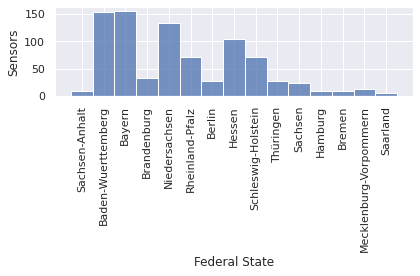

In [286]:
sns.histplot(data=pdm.metadata, x="federal_state")
plt.xticks(rotation=90)
#plt.title("Number of Sensors per Federal State")
plt.ylabel("Sensors")
plt.xlabel("Federal State")
plt.tight_layout()
plt.savefig("sensor_number.pdf")
plt.show()

In [12]:
len(pdm.metadata)

848

In [13]:
pdm.metadata.measures_to.max()

'2023-02-01T00:00:00'

In [14]:
pdm.data.isnull().sum(axis=1).iloc[-100:]

time
2022-12-30 23:15:00    660
2022-12-30 23:30:00    660
2022-12-30 23:45:00    660
2022-12-31 00:00:00    660
2022-12-31 00:15:00    660
                      ... 
2022-12-31 23:00:00    660
2022-12-31 23:15:00    660
2022-12-31 23:30:00    660
2022-12-31 23:45:00    660
2023-01-01 00:00:00    660
Length: 100, dtype: int64

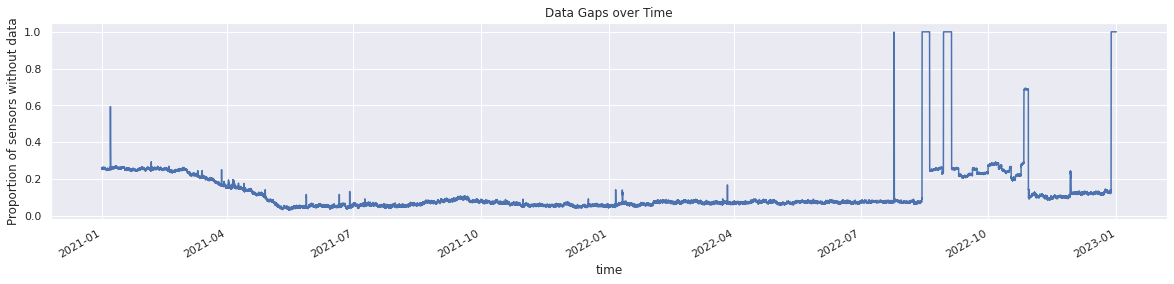

In [269]:
(pdm.data.isnull().sum(axis=1)/len(pdm.data.columns)).plot(figsize=(20,4))
plt.title("Data Gaps over Time")
plt.ylabel("Proportion of sensors without data")
plt.savefig("./data_gaps.pdf")

In [18]:
len(pdm.metadata)

848

In [17]:
set(pdm.data.columns.values) - set(pdm.metadata.sensor_id.unique())

set()

<AxesSubplot:xlabel='time'>

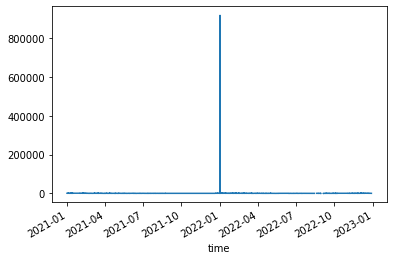

In [21]:
pdm.back_transform(pdm.data.mean(axis=1)).plot()

In [47]:
pdm.data.where(pdm.data == 1.0)

id,001dce72-b1c1-44b1-bf16-0c22cfe3a420,00a3c3e4-bf1f-4c0b-9e18-8bc60e66575d,00f8ec53-2c1c-4eeb-a159-5f4881907a72,0247a559-2660-4434-b204-d8f7ef9da4d4,0252a8f5-9913-47bb-a70f-c86e5c69f71a,02a7475b-9007-4aef-a265-b38bbdbbec32,0320fee3-66fb-4f70-b139-ff45d4e03a17,0358067f-cd41-4d91-ba9e-91405fbfc704,037d3c0e-2c33-4705-a6a4-778ce0858c85,03b8c76b-aee3-473e-8f25-c21cea1e0ba6,...,fb66b0f7-16cf-4bdc-8099-745f2c6e39e4,fc4ee653-5aed-4375-8fec-87de4147471a,fcf879e3-b960-4d3b-91eb-a7c9b7eab187,fd440cb5-d81e-40ee-9819-8395a61c3a35,fd53424d-2cfa-4a08-8010-98a2b1aec35f,fdc9f3b1-aabf-4a4a-8f12-1db945883b48,fe352710-860f-4686-ad4e-e187e99c7256,fe3e7a4a-1e6f-446b-9f12-86824c85d23a,feaefbc3-fb58-4165-a39f-c28df81abd55,ff029d36-1c57-43fc-922f-2c148c3f6200
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 23:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Average Power consumption over time'}, xlabel='time', ylabel='Average power consumption [W]'>

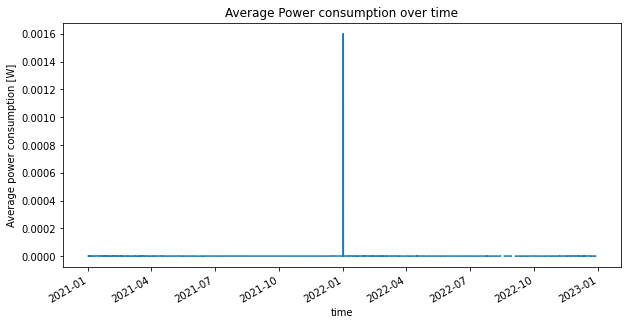

In [32]:
pdm.data.mean(axis=1).plot(figsize=(10,5), title="Average Power consumption over time", ylabel="Average power consumption [W]")

In [133]:
pdm.metadata

,sensor_id,measures_from,measures_to,notes,area,category,construction_year,city,federal_state,country,lat,lon,post_code,usage,usage_detail
0,4d02a52a-81c8-44b8-bed1-c9a8a6bde669,2019-02-08T00:00:00,2023-02-01T00:00:00,None,110.0,Privat,NaN,Hettstedt,Sachsen-Anhalt,Deutschland,51.650005,11.499999,6333,Haushalt,None
1,5b92fb08-c81e-4d53-b645-34d665cb31c2,2021-04-26T00:00:00,2023-02-01T00:00:00,None,235.0,Privat,NaN,Mannheim,Baden-Wuerttemberg,Deutschland,49.489291,8.467310,68307,Haushalt,None
2,1834a95b-72e7-43c6-8cb8-2e44f23baaae,2021-03-31T00:00:00,2023-02-01T00:00:00,None,140.0,Privat,NaN,Parsdorf,Bayern,Deutschland,48.141898,11.787412,85599,Haushalt,None
3,9081bf52-436e-4560-a8af-e0fab319dd06,2020-11-23T00:00:00,2023-02-01T00:00:00,None,132.0,Privat,NaN,Bergerdamm,Brandenburg,Deutschland,52.655278,12.804353,14641,Haushalt,None
4,ddad5aec-cf51-4321-a649-3fa209c1498c,2018-03-23T00:00:00,2023-02-01T00:00:00,None,120.0,Privat,NaN,Plankenfels,Bayern,Deutschland,49.886891,11.336763,95515,Haushalt,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,0b8efd0d-2944-4300-87fe-47be4fb8500f,2020-02-27T00:00:00,2023-02-01T00:00:00,None,150.0,Privat,NaN,Walldorf,Thüringen,Deutschland,49.303813,8.643352,69190,Haushalt,None
844,e8d5afeb-1ea9-4121-b14f-48f939624c7e,2020-02-20T00:00:00,2023-02-01T00:00:00,None,250.0,Privat,NaN,Mauth,Bayern,Deutschland,48.888914,13.584140,94151,Haushalt,None
845,1885cf63-5f31-45b9-94ab-f7f7815d3bed,2020-02-05T00:00:00,2023-02-01T00:00:00,None,45.0,Privat,NaN,Hamburg Uhlenhorst,Hamburg,Deutschland,53.568455,10.023853,22087,Haushalt,None
846,718d8e77-f83f-4856-840d-8df0a3d09da8,2020-08-06T00:00:00,2023-02-01T00:00:00,None,120.0,Privat,NaN,Uetze,Niedersachsen,Deutschland,52.435575,10.166022,31311,Haushalt,None


In [161]:
import seaborn as sns
sns.set()

In [170]:
(pdm.metadata["category"] == "Oeffentlich").sum()

42

In [177]:
(df["category"] == "Oeffentlich").sum()

1

In [187]:
df.drop("16aa1678-a581-4dfa-a91e-17f48bdfd4d3")

,w,measures_from,measures_to,notes,area,category,construction_year,city,federal_state,country,lat,lon,post_code,usage,usage_detail
id,,,,,,,,,,,,,,,
001dce72-b1c1-44b1-bf16-0c22cfe3a420,1.214496e-06,2020-03-05T00:00:00,2023-02-01T00:00:00,None,148.0,Privat,NaN,Jersbek,Schleswig-Holstein,Deutschland,53.745157,10.212754,22941,Haushalt,None
00a3c3e4-bf1f-4c0b-9e18-8bc60e66575d,5.094346e-07,2017-10-04T00:00:00,2023-02-01T00:00:00,None,75.0,Privat,NaN,Nürnberg,Bayern,Deutschland,49.453872,11.077298,90411,Haushalt,None
00f8ec53-2c1c-4eeb-a159-5f4881907a72,1.636302e-10,2021-04-28T00:00:00,2023-02-01T00:00:00,None,150.0,Privat,NaN,Schauenburg,Hessen,Deutschland,51.277697,9.348240,34270,Haushalt,None
0247a559-2660-4434-b204-d8f7ef9da4d4,6.745809e-07,2021-05-05T00:00:00,2023-02-01T00:00:00,None,141.0,Privat,NaN,Hamburg,Schleswig-Holstein,Deutschland,53.594138,9.995974,22299,Haushalt,None
0252a8f5-9913-47bb-a70f-c86e5c69f71a,3.572780e-07,2020-01-23T00:00:00,2023-02-01T00:00:00,None,145.0,Privat,NaN,Darmstadt,Hessen,Deutschland,49.885187,8.673630,64289,Haushalt,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fdc9f3b1-aabf-4a4a-8f12-1db945883b48,7.561422e-07,2019-05-22T00:00:00,2023-02-01T00:00:00,None,148.0,Privat,NaN,Meppen,Niedersachsen,Deutschland,52.701926,7.306418,49716,Haushalt,None
fe352710-860f-4686-ad4e-e187e99c7256,9.739095e-07,2021-03-03T00:00:00,2023-02-01T00:00:00,None,222.0,Privat,NaN,Rohr in Niederbayern,Bayern,Deutschland,48.768098,11.969356,93352,Haushalt,None
fe3e7a4a-1e6f-446b-9f12-86824c85d23a,1.586464e-06,2020-08-06T00:00:00,2023-02-01T00:00:00,None,250.0,Gewerblich,NaN,Kiebitzreihe,Schleswig-Holstein,Deutschland,53.780327,9.619588,25368,Firma,None


id
001dce72-b1c1-44b1-bf16-0c22cfe3a420    696.262480
00a3c3e4-bf1f-4c0b-9e18-8bc60e66575d    292.055580
00f8ec53-2c1c-4eeb-a159-5f4881907a72      0.093808
0247a559-2660-4434-b204-d8f7ef9da4d4    386.732886
0252a8f5-9913-47bb-a70f-c86e5c69f71a    204.825201
                                           ...    
fdc9f3b1-aabf-4a4a-8f12-1db945883b48    433.491466
fe352710-860f-4686-ad4e-e187e99c7256    558.336029
fe3e7a4a-1e6f-446b-9f12-86824c85d23a    909.509324
feaefbc3-fb58-4165-a39f-c28df81abd55      0.929745
ff029d36-1c57-43fc-922f-2c148c3f6200    226.780737
Name: w, Length: 659, dtype: float64

/home/bschaefermeier/.local/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 28.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/bschaefermeier/.local/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/bschaefermeier/.local/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 24.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/bschaefermeier/.local/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 23.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/bschaefermeier/.local/lib/python3.7/site-packa

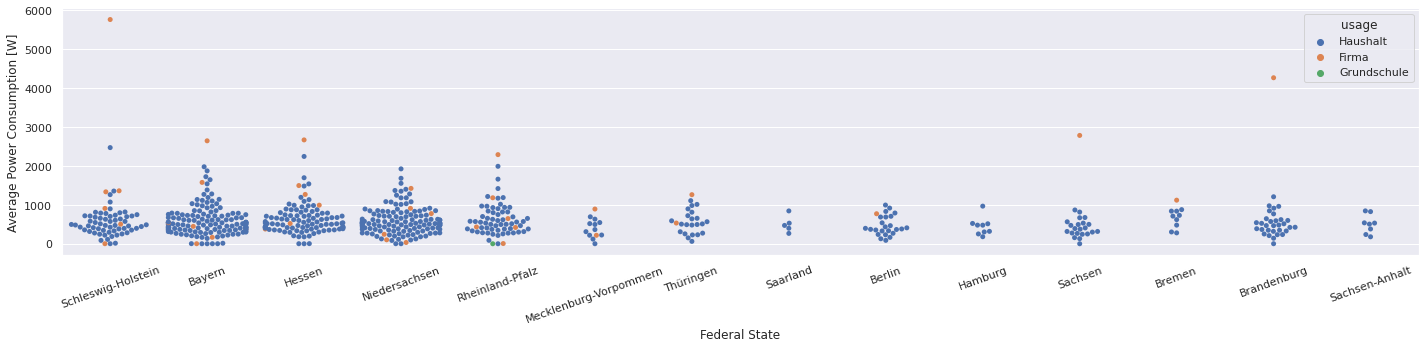

In [288]:
plt.figure(figsize=(20,5))
sns.swarmplot(data=df, x="federal_state", y="w", hue="usage")
plt.xticks(rotation=20)
plt.xlabel("Federal State")
plt.ylabel("Average Power Consumption [W]")
plt.tight_layout()
plt.savefig("./power_by_federalstate_swarmplot_allsensors.pdf")
plt.show()

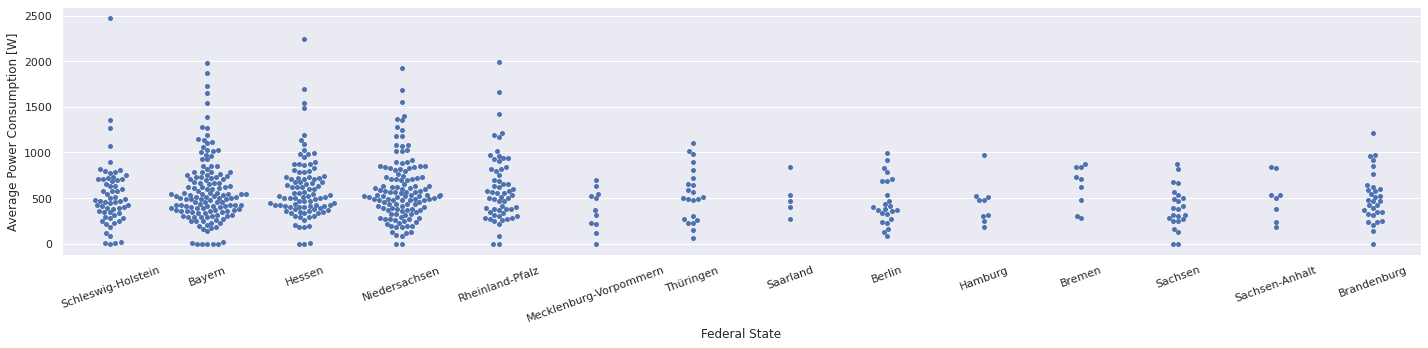

In [265]:
plt.figure(figsize=(20,5))
sns.swarmplot(data=df[df["category"]=="Privat"], x="federal_state", y="w")
plt.xticks(rotation=20)
plt.xlabel("Federal State")
plt.ylabel("Average Power Consumption [W]")
plt.tight_layout()
plt.savefig("./power_by_federalstate_swarmplot.pdf")
plt.show()

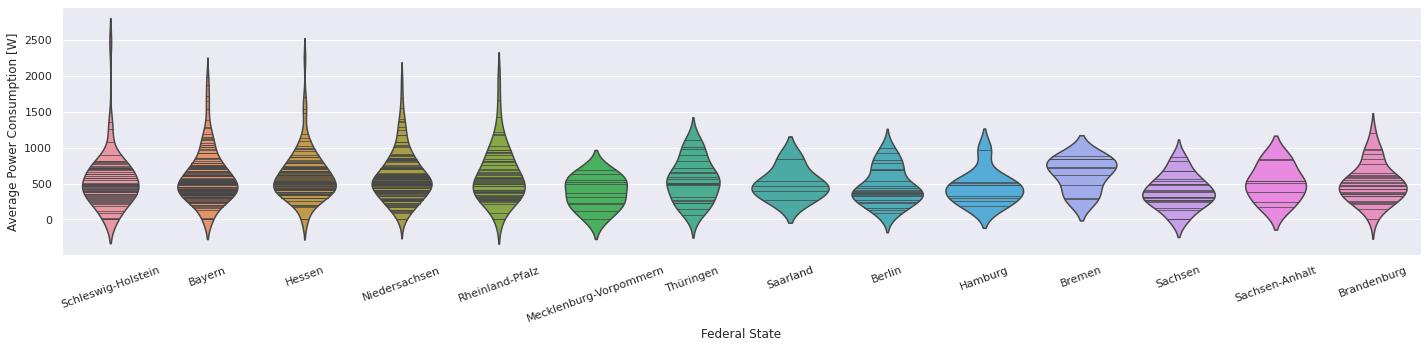

In [266]:
plt.figure(figsize=(20,5))
sns.violinplot(data=df[df["category"]=="Privat"], x="federal_state", y="w", inner="stick")
#sns.swarmplot(data=df[df["category"]=="Privat"], x="federal_state", y="w", size=3, color="white")
plt.xticks(rotation=20)
plt.xlabel("Federal State")
plt.ylabel("Average Power Consumption [W]")
plt.tight_layout()
plt.savefig("./power_by_federalstate_violinplot.pdf")
plt.show()

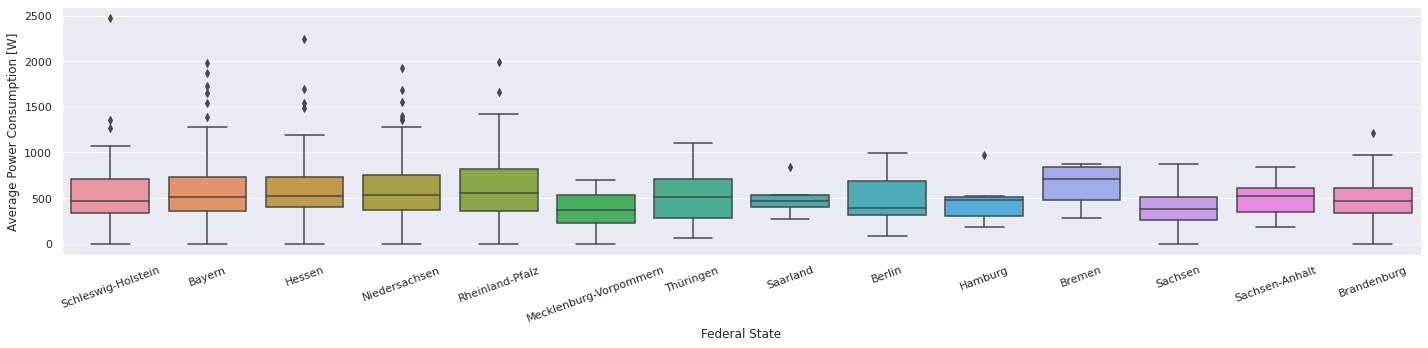

In [267]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df[df["category"]=="Privat"], x="federal_state", y="w")
plt.xticks(rotation=20)
plt.xlabel("Federal State")
plt.ylabel("Average Power Consumption [W]")
plt.tight_layout()
plt.savefig("./power_by_federalstate_boxplot.pdf")
plt.show()

In [260]:
households_to_use = set(df[df["category"]=="Privat"].index.values)-set("16aa1678-a581-4dfa-a91e-17f48bdfd4d3")
str(list(households_to_use))

"['22d3fd2c-a23d-4620-899a-1faee6da511c', '28769f0b-7601-4e5e-823f-97f8ef469910', 'e016926c-fa5c-49a7-a715-6b30d4aab4ed', '18025781-5a6c-4489-a850-7ba0f76eaadc', '8a579476-1069-4087-9ac2-12f728a6cc66', 'e58f2df6-778c-44d8-9c51-1deb5afd99a5', '6b253309-89b7-4282-a2f6-337284356dab', '5c8fbb63-735e-44ec-8f2f-0e0d99aadbfd', '2ed46eeb-bb38-4bd4-b16b-85db6f9f4267', 'cce1b7bc-4290-4312-8534-db7bc2b23a8f', '24595c1e-dd40-4c2e-b2d0-f8499ea7bd7b', '376c1716-47cd-4972-ad72-5ff9bd0e96c1', '8fabd8cb-1261-464b-a0c7-84b948bba530', 'b68504d5-b0d7-44af-a129-745dcc7f4345', 'fa90c793-cba7-4cb7-baad-3b0d8358fa87', '2241a124-0e4c-4b18-abb0-0e31108c543b', 'b06afddc-157f-4acb-a3c0-dabd217e47a9', '7558ee98-7e2c-443c-90af-fc0e7e247ef5', 'cec3d5cc-0548-43b4-9d62-772cae2f6034', '7aaf6ed0-00d8-447b-80ea-ddab8849f36c', 'c6f7ab70-0be6-4531-a65c-1d18e57a9aad', 'b2014e5b-0fce-4bf7-9088-36474df74662', 'b1a70e4d-45a4-449a-8f67-e66c21f12d85', 'd3f8e8c4-32ec-4035-a9b5-ba8c945caa4b', '6b0845f1-fbf6-40fb-9a69-9d104cfa75c6'

<AxesSubplot:xlabel='area', ylabel='w'>

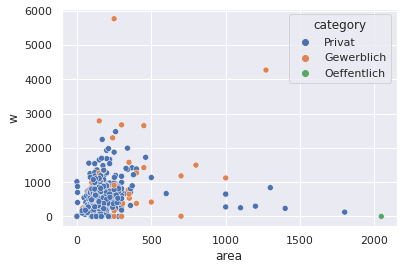

In [203]:
df = pd.DataFrame(pdm.data.mean(axis=0))
# Remove Outlier household with extremely high power consumption and area
df = df.drop("16aa1678-a581-4dfa-a91e-17f48bdfd4d3") 
df = df.join(pdm.metadata.set_index("sensor_id"), on=df.index).rename(columns={0: "w"})
df["w"] = pdm.back_transform(df["w"])
sns.scatterplot(data=df, x="area", y="w", hue="category")
#plt.xlim(0,500)

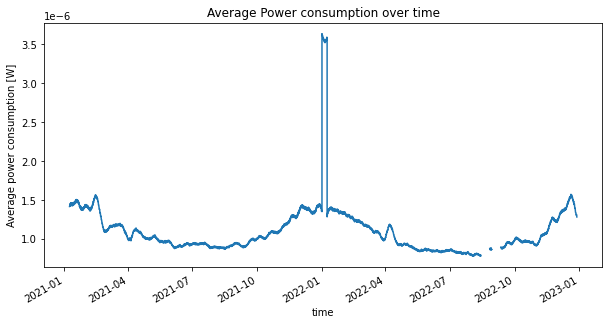

In [31]:
pdm.data.mean(axis=1).rolling(700).mean().plot(figsize=(10,5), title="Average Power consumption over time", ylabel="Average power consumption [W]")
#plt.ylim(0,)
plt.savefig("./power_overtime_2021_2022.pdf")

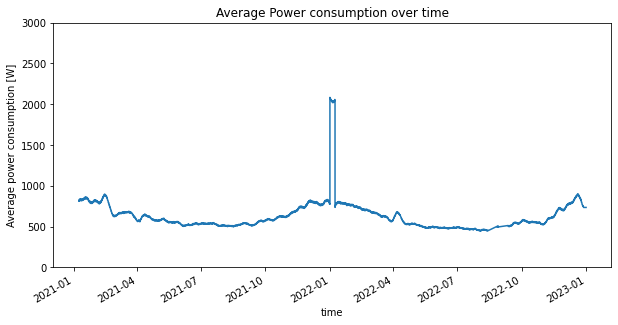

In [91]:
pdm.back_transform(pdm.data.mean(axis=1)).rolling(700).mean().interpolate().plot(figsize=(10,5), title="Average Power consumption over time", ylabel="Average power consumption [W]")
plt.ylim(0,3000)
plt.savefig("./power_overtime_2021_2022.pdf")

In [69]:
pdm.data.columns[46]

'16aa1678-a581-4dfa-a91e-17f48bdfd4d3'

In [83]:
pdm.metadata

,sensor_id,measures_from,measures_to,notes,area,category,construction_year,city,federal_state,country,lat,lon,post_code,usage,usage_detail
0,4d02a52a-81c8-44b8-bed1-c9a8a6bde669,2019-02-08T00:00:00,2023-02-01T00:00:00,None,110.0,Privat,NaN,Hettstedt,Sachsen-Anhalt,Deutschland,51.650005,11.499999,6333,Haushalt,None
1,5b92fb08-c81e-4d53-b645-34d665cb31c2,2021-04-26T00:00:00,2023-02-01T00:00:00,None,235.0,Privat,NaN,Mannheim,Baden-Wuerttemberg,Deutschland,49.489291,8.467310,68307,Haushalt,None
2,1834a95b-72e7-43c6-8cb8-2e44f23baaae,2021-03-31T00:00:00,2023-02-01T00:00:00,None,140.0,Privat,NaN,Parsdorf,Bayern,Deutschland,48.141898,11.787412,85599,Haushalt,None
3,9081bf52-436e-4560-a8af-e0fab319dd06,2020-11-23T00:00:00,2023-02-01T00:00:00,None,132.0,Privat,NaN,Bergerdamm,Brandenburg,Deutschland,52.655278,12.804353,14641,Haushalt,None
4,ddad5aec-cf51-4321-a649-3fa209c1498c,2018-03-23T00:00:00,2023-02-01T00:00:00,None,120.0,Privat,NaN,Plankenfels,Bayern,Deutschland,49.886891,11.336763,95515,Haushalt,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,0b8efd0d-2944-4300-87fe-47be4fb8500f,2020-02-27T00:00:00,2023-02-01T00:00:00,None,150.0,Privat,NaN,Walldorf,Thüringen,Deutschland,49.303813,8.643352,69190,Haushalt,None
844,e8d5afeb-1ea9-4121-b14f-48f939624c7e,2020-02-20T00:00:00,2023-02-01T00:00:00,None,250.0,Privat,NaN,Mauth,Bayern,Deutschland,48.888914,13.584140,94151,Haushalt,None
845,1885cf63-5f31-45b9-94ab-f7f7815d3bed,2020-02-05T00:00:00,2023-02-01T00:00:00,None,45.0,Privat,NaN,Hamburg Uhlenhorst,Hamburg,Deutschland,53.568455,10.023853,22087,Haushalt,None
846,718d8e77-f83f-4856-840d-8df0a3d09da8,2020-08-06T00:00:00,2023-02-01T00:00:00,None,120.0,Privat,NaN,Uetze,Niedersachsen,Deutschland,52.435575,10.166022,31311,Haushalt,None


In [90]:
pdm.metadata[pdm.metadata["area"]>500]

,sensor_id,measures_from,measures_to,notes,area,category,construction_year,city,federal_state,country,lat,lon,post_code,usage,usage_detail
26,301fae5d-7349-4d7e-a225-70f214191775,2019-12-16T00:00:00,2023-02-01T00:00:00,None,1271.0,Gewerblich,NaN,Treuenbrietzen,Brandenburg,Deutschland,52.048842,12.942526,14929,Firma,None
29,c6f7ab70-0be6-4531-a65c-1d18e57a9aad,2019-01-04T00:00:00,2023-02-01T00:00:00,None,1800.0,Privat,NaN,Wilhelmshaven,Niedersachsen,Deutschland,53.529121,8.132930,26384,Haushalt,None
82,67b50ba2-335f-4eeb-9632-aab92859f5c3,2019-02-21T00:00:00,2023-02-01T00:00:00,None,1200.0,Privat,NaN,Königsbrunn,Bayern,Deutschland,48.268452,10.877149,86343,Haushalt,None
199,151d956a-53ee-480c-91a6-2aa5afcce049,2019-01-22T00:00:00,2023-02-01T00:00:00,None,1000.0,Privat,NaN,Kirchhain,Hessen,Deutschland,50.821451,8.931128,35274,Haushalt,None
200,d068fe37-f8a8-4e33-a5c1-c046f96a8af4,2019-04-24T00:00:00,2023-02-01T00:00:00,None,1400.0,Privat,NaN,Visselhövede,Niedersachsen,Deutschland,52.989139,9.586932,27374,Haushalt,None
214,64d01c05-a7e4-4f48-b673-7b29c84c5710,2021-05-14T00:00:00,2023-02-01T00:00:00,None,700.0,Gewerblich,NaN,Kerpen,Rheinland-Pfalz,Deutschland,50.869634,6.694734,50170,Firma,None
238,496c2180-0316-4b60-8d9c-9582422529e1,2021-03-18T00:00:00,2023-02-01T00:00:00,None,550.0,Privat,NaN,Freiburg im Breisgau,Baden-Wuerttemberg,Deutschland,47.996090,7.849400,79100,Haushalt,None
284,1659bb8f-768c-43a5-98d6-7343b146cc74,2020-09-01T00:00:00,2023-02-01T00:00:00,None,1100.0,Privat,NaN,Lehrte,Niedersachsen,Deutschland,52.377210,9.914497,31275,Haushalt,None
308,ef67f92e-0be2-4f7b-9aa0-094149b1e1e4,2018-10-23T00:00:00,2023-02-01T00:00:00,None,1300.0,Privat,NaN,Bremen,Bremen,Deutschland,53.075820,8.807165,28215,Haushalt,None
314,cf0c2919-caae-4651-b89d-28c7ab609f2e,2020-01-14T00:00:00,2022-11-04T00:00:00,None,800.0,Gewerblich,NaN,Heppenheim (Bergstraße),Hessen,Deutschland,49.641614,8.633333,64646,Firma,None


[]

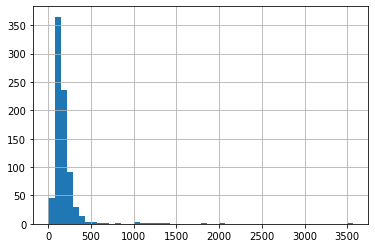

In [89]:
pdm.metadata.area.hist(bins=50).plot()

In [85]:
pdm.metadata[pdm.metadata.sensor_id=='16aa1678-a581-4dfa-a91e-17f48bdfd4d3']

,sensor_id,measures_from,measures_to,notes,area,category,construction_year,city,federal_state,country,lat,lon,post_code,usage,usage_detail
486,16aa1678-a581-4dfa-a91e-17f48bdfd4d3,2019-09-06T00:00:00,2023-02-01T00:00:00,None,3565.0,Privat,NaN,Berlin,Berlin,Deutschland,52.448455,13.583903,12555,Haushalt,None


In [119]:
tdf = pdm.data.copy()

In [128]:
tdf.applymap(lambda x: x if x < 100000 else np.NaN)

id,001dce72-b1c1-44b1-bf16-0c22cfe3a420,00a3c3e4-bf1f-4c0b-9e18-8bc60e66575d,00f8ec53-2c1c-4eeb-a159-5f4881907a72,0247a559-2660-4434-b204-d8f7ef9da4d4,0252a8f5-9913-47bb-a70f-c86e5c69f71a,02a7475b-9007-4aef-a265-b38bbdbbec32,0320fee3-66fb-4f70-b139-ff45d4e03a17,0358067f-cd41-4d91-ba9e-91405fbfc704,037d3c0e-2c33-4705-a6a4-778ce0858c85,03b8c76b-aee3-473e-8f25-c21cea1e0ba6,...,fb66b0f7-16cf-4bdc-8099-745f2c6e39e4,fc4ee653-5aed-4375-8fec-87de4147471a,fcf879e3-b960-4d3b-91eb-a7c9b7eab187,fd440cb5-d81e-40ee-9819-8395a61c3a35,fd53424d-2cfa-4a08-8010-98a2b1aec35f,fdc9f3b1-aabf-4a4a-8f12-1db945883b48,fe352710-860f-4686-ad4e-e187e99c7256,fe3e7a4a-1e6f-446b-9f12-86824c85d23a,feaefbc3-fb58-4165-a39f-c28df81abd55,ff029d36-1c57-43fc-922f-2c148c3f6200
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,0.000002,9.987455e-07,NaN,NaN,2.374067e-07,6.977111e-07,NaN,0.000001,7.004360e-07,NaN,...,NaN,NaN,5.009209e-07,6.430253e-07,0.000005,8.182972e-07,NaN,0.000003,NaN,4.360754e-07
2021-01-01 00:15:00,0.000002,8.646576e-07,NaN,NaN,2.137684e-07,7.414158e-07,NaN,0.000001,2.090838e-06,NaN,...,NaN,NaN,5.779894e-07,6.144692e-07,0.000006,8.502923e-07,NaN,0.000003,NaN,3.932809e-07
2021-01-01 00:30:00,0.000002,9.262941e-07,NaN,NaN,2.581431e-07,6.635598e-07,NaN,0.000001,5.592698e-07,NaN,...,NaN,NaN,5.704450e-07,5.934210e-07,0.000005,8.500182e-07,NaN,0.000002,NaN,4.757274e-07
2021-01-01 00:45:00,0.000002,1.023152e-06,NaN,NaN,2.334916e-07,6.787339e-07,NaN,0.000001,1.500622e-06,NaN,...,NaN,NaN,5.961451e-07,5.487445e-07,0.000006,5.696233e-07,NaN,0.000002,NaN,5.074783e-07
2021-01-01 01:00:00,0.000002,9.521288e-07,NaN,NaN,1.997051e-07,8.001907e-07,NaN,0.000001,1.897785e-06,NaN,...,NaN,NaN,5.794187e-07,5.756572e-07,0.000003,5.888939e-07,NaN,0.000002,NaN,5.492246e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 23:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='time'>

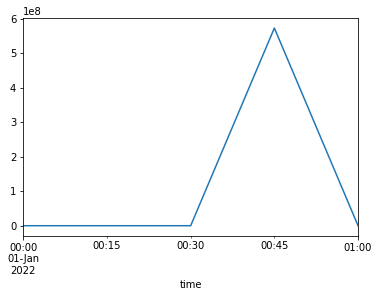

In [117]:
pdm.back_transform(pdm.data.loc["2022-01-01 0:00:00":"2022-01-01 01:00:00", '16aa1678-a581-4dfa-a91e-17f48bdfd4d3']).plot()

<AxesSubplot:xlabel='time'>

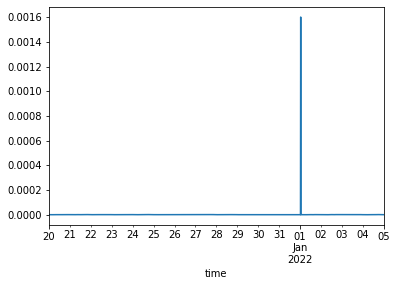

In [78]:
pdm.data["2021-12-20 00:00:00":"2022-01-05 00:00:00"].mean(axis=1).plot()

In [50]:
pdm.minmax

(0.0, 99998.1457588)

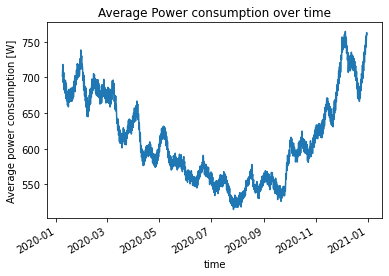

In [128]:
pdm.back_transform(pdm.data.mean(axis=1)).rolling(700).mean().plot(title="Average Power consumption over time", ylabel="Average power consumption [W]")
plt.savefig("./power_overtime.pdf")

In [89]:
powerdf = pd.DataFrame(pdm.back_transform(pdm.data.mean(axis=0)), columns=["mean_w"]).join(pdm.metadata.set_index("sensor_id"))
for datecol in ["measures_from", "measures_to"]:
    powerdf[datecol] = powerdf[datecol].astype(np.Datetime64)
powerdf.head()

,mean_w,measures_from,measures_to,notes,area,category,construction_year,city,federal_state,country,lat,lon,post_code,usage,usage_detail
id,,,,,,,,,,,,,,,
0358067f-cd41-4d91-ba9e-91405fbfc704,558.488084,2019-06-09,2023-02-01,None,135.0,Privat,None,Hambühren,Niedersachsen,Deutschland,52.626704,9.966328,29313,Haushalt,None
06d1421b-265b-4a13-a39f-6df00dbf92a6,328.367277,2020-09-08,2023-02-01,None,168.0,Privat,None,Admannshagen-Bargeshagen,Mecklenburg-Vorpommern,Deutschland,54.130834,12.001205,18211,Haushalt,None
0cc0fcd7-ba31-4b36-abd6-a59b9700918c,411.883289,2020-07-14,2023-02-01,None,100.0,Privat,None,Bissendorf,Niedersachsen,Deutschland,52.229279,8.240915,49143,Haushalt,None
1178737b-13d0-4f18-be37-485975448f37,453.517131,2019-04-26,2023-02-01,None,100.0,Privat,None,Wildeshausen,Niedersachsen,Deutschland,52.918384,8.324462,27793,Haushalt,None
126327a9-1748-498c-a52d-d333b3879074,384.411255,2019-05-28,2023-02-01,None,260.0,Privat,None,Messingen,Niedersachsen,Deutschland,52.466536,7.460015,49832,Haushalt,None


In [101]:
filteredpowerdf = powerdf[(np.datetime64(start_date) <= powerdf["measures_from"]) & (np.datetime64(end_date) <= powerdf["measures_to"])]

/share/apps/anaconda/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """Entry point for launching an IPython kernel.


In [102]:
filteredpowerdf.groupby("category").mean()

,mean_w,area,lat,lon,post_code
category,,,,,
Gewerblich,770.381413,262.00,52.506048,10.129352,34653.333333
Privat,536.463287,171.75,52.770933,9.601313,30446.450000


In [ ]:
plt.figure()
for name, group in filteredpowerdf.groupby("category"):
    plt.scatter(group["area"], group["mean_w"], label=name, marker="x")
plt.legend()
plt.xlabel("Area [$m^2$]")
plt.ylabel("Average Power Consumption [$W$]")
plt.savefig("power_bycategory.pdf")
plt.show()

In [46]:
pdm.metadata

,sensor_id,measures_from,measures_to,notes,area,category,construction_year,city,federal_state,country,lat,lon,post_code,usage,usage_detail
0,4ce8d71e-405c-4825-b582-9953d66b6f59,2021-03-17T00:00:00,2023-02-01T00:00:00,None,4.0,Gewerblich,None,Wilhelmshaven,Niedersachsen,Deutschland,53.522826,8.095634,26382,Firma,None
1,e2233e46-5e84-4bde-9fb6-94018b7ee48c,2021-04-14T00:00:00,2023-02-01T00:00:00,None,240.0,Privat,None,Gnarrenburg,Niedersachsen,Deutschland,53.387830,8.980908,27442,Haushalt,None
2,6e77f347-726a-4b41-a259-c9b55ae723eb,2021-05-06T00:00:00,2023-02-01T00:00:00,None,220.0,Privat,None,Garbsen,Niedersachsen,Deutschland,52.427401,9.508898,30826,Haushalt,None
3,ccca55e4-25e2-4f2e-a48b-6ca1ec31d96e,2020-01-28T00:00:00,2023-01-30T00:00:00,None,230.0,Privat,None,Katlenburg-Lindau,Niedersachsen,Deutschland,51.679913,10.099175,37191,Haushalt,None
4,d37837d5-c260-432b-8469-2e93b809b68c,2020-09-08T00:00:00,2023-02-01T00:00:00,None,360.0,Privat,None,Haren,Niedersachsen,Deutschland,52.790562,7.240027,49733,Haushalt,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,6205b6cc-e9ae-4065-8b74-7e0e52e42b49,2021-03-22T00:00:00,2023-02-01T00:00:00,None,88.0,Privat,None,Sandstedt,Niedersachsen,Deutschland,53.309532,8.531054,27628,Haushalt,None
161,e360e958-e0ce-4c2f-94e2-01e31d151b32,2020-06-02T00:00:00,2023-02-01T00:00:00,None,372.0,Privat,None,Delmenhorst,Niedersachsen,Deutschland,53.061342,8.616390,27753,Haushalt,None
162,e3d680e9-f25e-4f69-9f51-550fede78c99,2021-03-23T00:00:00,2023-02-01T00:00:00,None,140.0,Privat,None,Bremen,Bremen,Deutschland,53.193815,8.541798,28777,Haushalt,None
163,1885cf63-5f31-45b9-94ab-f7f7815d3bed,2020-02-05T00:00:00,2023-02-01T00:00:00,None,45.0,Privat,None,Hamburg Uhlenhorst,Hamburg,Deutschland,53.568455,10.023853,22087,Haushalt,None


<AxesSubplot:>

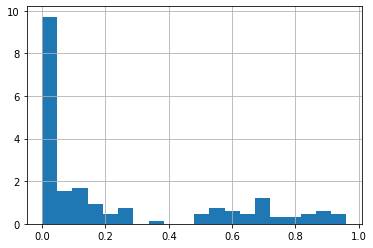

In [31]:
nullvals = pdm.data.isnull().sum()
nonnullvals = pdm.data.notnull().sum()
(nullvals/(nullvals+nonnullvals)).hist(density=True, bins=20)

In [259]:
data.shape

torch.Size([36971, 1, 96])

In [238]:
list_data.isnan().sum()

tensor(0)

In [264]:
pdm.train_df.shape

(34849, 137)

In [195]:
series = list_data.numpy().reshape(list_data.shape[0], list_data.shape[-1])
mean = series.mean(axis=0)
std = series.std(axis=0)

In [228]:
series.shape

(707, 96)

In [235]:
density = np.histogram(series, density=True, bins=96)

In [234]:
density[0].shape

(10,)

In [226]:
density

(array([7.15509838e+01, 7.73907815e+00, 2.44140748e+00, 3.86709155e-01,
        5.86182548e-01, 8.19921309e-02, 3.18178419e-02, 4.52792365e-02,
        0.00000000e+00, 1.95802104e-01]),
 array([0.        , 0.0120396 , 0.0240792 , 0.03611879, 0.04815839,
        0.06019799, 0.07223759, 0.08427719, 0.09631678, 0.10835638,
        0.12039598]))

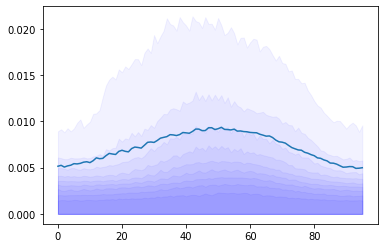

In [222]:
plt.figure()
plt.plot(mean_series)
percentiles = np.percentile(series, q=[10,20,30,40,50,60,70,80,90], axis=0)
for percentile in percentiles:
    plt.fill_between(list(range(96)), percentile, alpha=0.05, color="blue")
plt.show()

In [173]:
list_data.shape

torch.Size([707, 1, 0])

In [174]:
list_labels.shape

torch.Size([707, 137])

In [4]:
pdm.metadata

,sensor_id,measures_from,measures_to,notes,area,category,construction_year,city,federal_state,country,lat,lon,post_code,usage,usage_detail
0,4ce8d71e-405c-4825-b582-9953d66b6f59,2021-03-17T00:00:00,2023-02-01T00:00:00,None,4.0,Gewerblich,None,Wilhelmshaven,Niedersachsen,Deutschland,53.522826,8.095634,26382,Firma,None
1,e2233e46-5e84-4bde-9fb6-94018b7ee48c,2021-04-14T00:00:00,2023-02-01T00:00:00,None,240.0,Privat,None,Gnarrenburg,Niedersachsen,Deutschland,53.387830,8.980908,27442,Haushalt,None
2,6e77f347-726a-4b41-a259-c9b55ae723eb,2021-05-06T00:00:00,2023-02-01T00:00:00,None,220.0,Privat,None,Garbsen,Niedersachsen,Deutschland,52.427401,9.508898,30826,Haushalt,None
3,ccca55e4-25e2-4f2e-a48b-6ca1ec31d96e,2020-01-28T00:00:00,2023-01-30T00:00:00,None,230.0,Privat,None,Katlenburg-Lindau,Niedersachsen,Deutschland,51.679913,10.099175,37191,Haushalt,None
4,d37837d5-c260-432b-8469-2e93b809b68c,2020-09-08T00:00:00,2023-02-01T00:00:00,None,360.0,Privat,None,Haren,Niedersachsen,Deutschland,52.790562,7.240027,49733,Haushalt,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,6205b6cc-e9ae-4065-8b74-7e0e52e42b49,2021-03-22T00:00:00,2023-02-01T00:00:00,None,88.0,Privat,None,Sandstedt,Niedersachsen,Deutschland,53.309532,8.531054,27628,Haushalt,None
161,e360e958-e0ce-4c2f-94e2-01e31d151b32,2020-06-02T00:00:00,2023-02-01T00:00:00,None,372.0,Privat,None,Delmenhorst,Niedersachsen,Deutschland,53.061342,8.616390,27753,Haushalt,None
162,e3d680e9-f25e-4f69-9f51-550fede78c99,2021-03-23T00:00:00,2023-02-01T00:00:00,None,140.0,Privat,None,Bremen,Bremen,Deutschland,53.193815,8.541798,28777,Haushalt,None
163,1885cf63-5f31-45b9-94ab-f7f7815d3bed,2020-02-05T00:00:00,2023-02-01T00:00:00,None,45.0,Privat,None,Hamburg Uhlenhorst,Hamburg,Deutschland,53.568455,10.023853,22087,Haushalt,None


In [20]:
start_date = '2020-01-01 00:00:00+02'
split_date = '2020-12-29 00:00:00'
end_date   = '2020-12-31 00:00:00+02'
non_pv_households = ['sfh10', 'sfh11', 'sfh12', 'sfh14', 'sfh16', 'sfh17', 'sfh18', 'sfh19', 'sfh20', 'sfh21', 'sfh22', 'sfh23', 'sfh25', 'sfh27', 'sfh28', 'sfh29', 'sfh3', 'sfh30', 'sfh31', 'sfh32', 'sfh34', 'sfh35', 'sfh36', 'sfh37', 'sfh38', 'sfh39', 'sfh4', 'sfh40', 'sfh5', 'sfh6', 'sfh7', 'sfh8', 'sfh9']
pdm = PowerDataModule(dataset="wpuq", assets = non_pv_households, start_date=start_date, end_date=end_date, split_date=split_date, load_metadata=True, drop_na=False, min_max_scale=True)
pdm.setup()

In [21]:
len(non_pv_households)

33

In [22]:
len(pdm.data.columns)

33

In [23]:
pdm.minmax

(24.68611113230385, 7506.149891493055)

## Evaluate the model

In [30]:
checkpoint_callback.best_model_score

In [31]:
def generate_synthetic_samples(generator, size: int = 5000,
                               clip: bool = True):
    generator.eval()
    z = torch.randn(size, generator.latent_dim).float()
    x_gen = generator(z).detach()
    x_gen = generator(z).detach()

    if clip:
        x_gen = torch.clamp(x_gen, 0, 1)
    return x_gen

In [32]:
def load_checkpoint(path):
    model = BaselineWGAN.load_from_checkpoint(path)
    model.eval()
    return model

LOAD_CHECKPOINT = True
if LOAD_CHECKPOINT:
    chkpt = '/share/data1/bschaefermeier/chkpt/wgan/BaselineWGAN_1-v1.ckpt'
    model = load_checkpoint(chkpt)

In [33]:
x_gen = generate_synthetic_samples(model.generator, clip=False)

In [34]:
from syndatagenerators.metrics.visualization import plot_TSNE
from syndatagenerators.models.utils.plot_functions import plot_sample_grid

../../syndatagenerators/models/utils/plot_functions.py:80: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sample = np.random.choice([x for x in data], n_rows*n_cols) if random_sample else data[:n_rows*n_cols]
../../syndatagenerators/models/utils/plot_functions.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.random.choice([x for x in data], n_rows*n_c

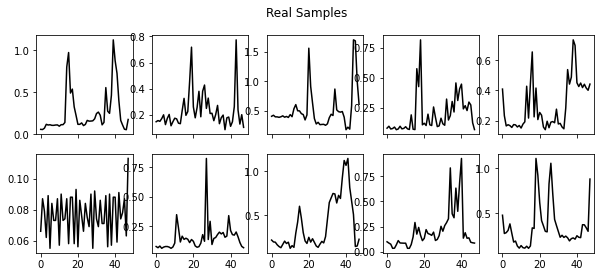

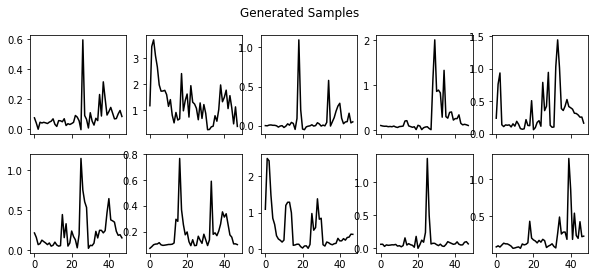

In [35]:
#realdatasample = np.random.choice(dataset, 16)
plot_sample_grid(train_data[:], random_sample=True, title='Real Samples')
fig = plot_sample_grid(x_gen, random_sample=True, title='Generated Samples')

/home/bschaefermeier/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/bschaefermeier/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


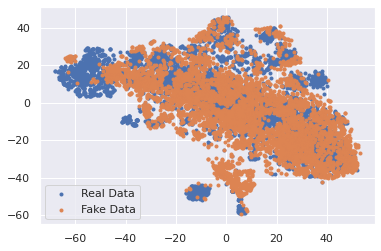

In [29]:
tsne_plot = plot_TSNE(test_data.dataset[:5000], x_gen, use_seaborn=True)

/home/bschaefermeier/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/bschaefermeier/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


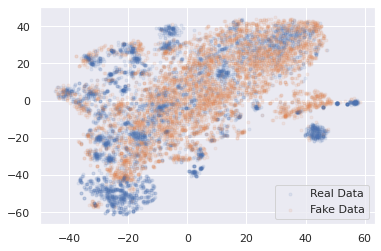

In [34]:
tsne_plot = plot_TSNE(test_data.dataset[:5000], x_gen, use_seaborn=True, alpha=0.1)

In [55]:
tsne_plot = plot_TSNE(torch.tensor(np.random.choice(train_data, 1944)), torch.tensor(np.random.choice(test_data, 1944)), use_seaborn=True, alpha=0.3)

/share/apps/anaconda/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.
/share/apps/anaconda/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [18]:
#mmd(val_data[:], x_gen)
mmd(test_data.dataset[:], x_gen)

tensor(0.0017)

In [39]:
mmd(val_data[:], test_data.dataset)

tensor(0.0011)

In [31]:
mmd(val_data[:], x_gen)

tensor(0.0020)

### Finetune WGAN model for each household. Calculate MMDs per household with and without finetuning.

In [36]:
import logging

# Config logger
logging.basicConfig(
  #encoding='utf-8',
  level=logging.DEBUG,
  filename="logs.txt")

# Redirect all warnings to log file
logging.captureWarnings(True)

In [37]:
# Collect household ids
households = set()
for x in datamodule.data:
    household_id = x["key"]
    households.add(x["key"])
len(households)

109

In [38]:
def finetune(model, household_id, train_data, val_data, epochs=20, accelerator="auto", dirpath="/share/data1/bschaefermeier/chkpt/wgan/finetune/"):
    """
    Finetune a pretrained WGAN for a given household.
    """
    savedir = f"{dirpath}/{household_id}"
    tb_logger = pl.loggers.TensorBoardLogger(save_dir=savedir)
    checkpoint_callback = ModelCheckpoint(dirpath=savedir, filename=f'{model.__class__.__name__}_{model.name}', every_n_epochs=10, save_top_k=1)
    callbacks = [checkpoint_callback]
    loader_train = DataLoader(train_data, batch_size=64, shuffle=False)
    trainer = pl.Trainer(logger=tb_logger, max_epochs=epochs, callbacks=callbacks, check_val_every_n_epoch=10, accelerator=accelerator)
    trainer.fit(model, loader_train, loader_val)
    return model

In [39]:
def calculate_household_mmds(modelchkpt, savefile, finetuning=False, epochs=100, accelerator="cpu", households_to_ignore=set()):
    """
    Calculates MMD for each household based on the corresponding test data and some generated data.
    """
    mmds = {}
    for household in households:
        # Ignore households which, e.g., have already been finetuned in a previous run.
        if household in households_to_ignore:
            continue

        # Get data for household.
        dm = DataChallengeDataModule(hdf5file, num_workers=8, household_id=household)
        train, test = dm.train_data, dm.test_data

        # Load base model and fine tune if activated.
        model = load_checkpoint(modelchkpt)
        if finetuning:
            train_size = int(len(train)*0.8)
            val_size = len(train) - train_size
            train_data, val_data = random_split(train, [train_size, val_size])
            finetune(model, household, train_data, val_data, epochs=epochs, accelerator=accelerator)

        # Generate sample data and calculate mmd
        xgen = generate_synthetic_samples(model.generator, clip=False)
        mmds[household] = mmd(xgen, test)

        # Save mmds
        data_to_save = [(k, v.numpy()) for k,v in mmds.items()]
        df = pd.DataFrame(data_to_save, columns=["household", "mmd"])
        df.to_csv(savefile, index=False)
    return mmds

In [40]:
modelchkpt = '/share/data1/bschaefermeier/chkpt/wgan/BaselineWGAN_1-v1.ckpt'

In [ ]:
# Calculate MMDS for all households (without finetuning).
calculate_household_mmds(modelchkpt, savefile='./mmds_all_households.csv', finetuning=False, accelerator="cpu")

In [42]:
# Optional: Collect households which have already been finetuned in a previous run.
mmds_finetuned = pd.read_csv('mmds_finetuned.csv')
finetuned_households = set(mmds_finetuned["household"].unique())
print(finetuned_households)
print(len(finetuned_households))

{'/MAC000108', '/MAC000104', '/MAC000119', '/MAC000076', '/MAC000075', '/MAC000012', '/MAC000097', '/MAC000031', '/MAC000027', '/MAC000099', '/MAC000017', '/MAC000090', '/MAC000005', '/MAC000037', '/MAC000070', '/MAC000087', '/MAC000115', '/MAC000002', '/MAC000057', '/MAC000010', '/MAC000116', '/MAC000020', '/MAC000006', '/MAC000105', '/MAC000117', '/MAC000021', '/MAC000023', '/MAC000062', '/MAC000018', '/MAC000073', '/MAC000059', '/MAC000088', '/MAC000109', '/MAC000046', '/MAC000026', '/MAC000107', '/MAC000015', '/MAC000033', '/MAC000032', '/MAC000092', '/MAC000101', '/MAC000078', '/MAC000034', '/MAC000014', '/MAC000048', '/MAC000102', '/MAC000066', '/MAC000091', '/MAC000103', '/MAC000043', '/MAC000004', '/MAC000047', '/MAC000029', '/MAC000072', '/MAC000052', '/MAC000038', '/MAC000061', '/MAC000106', '/MAC000054', '/MAC000030', '/MAC000098', '/MAC000039', '/MAC000060', '/MAC000045', '/MAC000036', '/MAC000112', '/MAC000009', '/MAC000055', '/MAC000053', '/MAC000096', '/MAC000084', '/MAC

In [ ]:
# Finetune base model for each household and calculate MMDs.
calculate_household_mmds(modelchkpt, savefile='./mmds_finetuned.csv', finetuning=True, epochs=100, accelerator="cpu", households_to_ignore=finetuned_households)

### Evaluate MMDs 

In [43]:
mmds = pd.read_csv('./mmds_all_households.csv')

In [44]:
mmds["mmd"].std()

0.10287533718534722

In [45]:
mean_mmd = mmds["mmd"].mean()
mean_mmd_finetuned = mmds_finetuned["mmd"].mean()
print("MMD over all households")
print("\t No finetuning \t Finetuned")
print(f"Mean:   \t {mean_mmd: .2f} \t {mean_mmd_finetuned: .2f}")
print(f"Stddev: \t {mmds['mmd'].std(): .2f} \t {mmds_finetuned['mmd'].std(): .2f}")

MMD over all households
	 No finetuning 	 Finetuned
Mean:   	  0.17 	  0.09
Stddev: 	  0.10 	  0.07


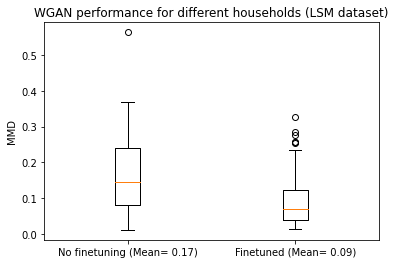

In [49]:
plt.figure()
labels = [f"No finetuning (Mean={np.mean(mmds['mmd']): .2f})", f"Finetuned (Mean={np.mean(mmds_finetuned['mmd']): .2f})"]
plt.boxplot([mmds["mmd"], mmds_finetuned["mmd"]], labels=labels)
plt.ylabel("MMD")
#plt.xticks(rotation=90)
plt.title("WGAN performance for different households (LSM dataset)")
#plt.boxplot(df_finetuned.mmd)
plt.savefig('wgan_performance.pdf')
plt.show()

### Diurnal average plots for generated and original data

In [ ]:
for f in listdir(models_folder):
    folder = os.path.join(models_folder, f, modelfile)
    if os.path.isfile(folder):
        print(folder)

In [76]:
import os
from os import listdir
models_folder = "/share/data1/bschaefermeier/chkpt/wgan/finetune/"
household_id = "MAC000007"
modelfile = "BaselineWGAN_1-v1.ckpt"

modelpath = f"{models_folder}{household_id}/{modelfile}"
wgan = load_checkpoint(modelpath)
xgen = generate_synthetic_samples(wgan.generator, clip=False).numpy()
xgen = xgen.reshape((xgen.shape[0], xgen.shape[-1]))
#mmds[household] = mmd(xgen, test)

In [94]:
#realdata = full_train_data.dataset.numpy()
realdata = test_data.dataset.numpy()
realdata = realdata.reshape((realdata.shape[0], realdata.shape[-1]))
realdata.mean(axis=0)

array([0.2448816 , 0.22803804, 0.2089211 , 0.18273456, 0.16111054,
       0.15262589, 0.14528286, 0.13825622, 0.13891256, 0.13784747,
       0.13937417, 0.14648108, 0.15819584, 0.17950214, 0.1906471 ,
       0.21099025, 0.22641805, 0.23501103, 0.23456527, 0.2399665 ,
       0.24397814, 0.24740052, 0.24933149, 0.25212064, 0.254793  ,
       0.2540376 , 0.25325748, 0.2493653 , 0.24870975, 0.25088942,
       0.25480026, 0.2653365 , 0.26882535, 0.2862133 , 0.30373397,
       0.3315021 , 0.35072073, 0.3645731 , 0.36688665, 0.36043537,
       0.35136542, 0.34232986, 0.33273026, 0.31872866, 0.2951851 ,
       0.27281886, 0.24065882, 0.20851624], dtype=float32)

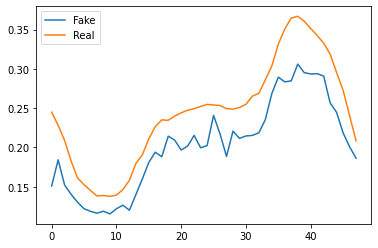

In [97]:
plt.figure()
plt.plot(xgen.mean(axis=0), label="Fake")
plt.plot(realdata.mean(axis=0), label="Real")
plt.legend()
plt.show()

In [55]:
!ls "/share/data1/bschaefermeier/chkpt/wgan/finetune/MAC000007"

BaselineWGAN_1-v1.ckpt	lightning_logs


### Load WPUQ or SNH data 

In [ ]:
sensor_ids = db.get_sensor_id(engine)
sensor_ids['living_space_m2'] = sensor_ids['living_space_m2'].astype(float)
sensor_ids['n_inhabitants'] = round(sensor_ids['n_inhabitants'].astype(float)).astype(int)

In [227]:
data.dtypes

time    datetime64[ns]
w              float64
id              object
dtype: object

array([[<AxesSubplot:title={'center':'w'}>]], dtype=object)

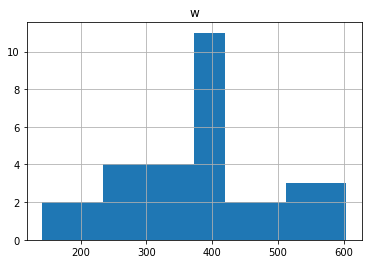

In [242]:
data.groupby('id').mean().hist()

In [234]:
# How many datapoints are there for one year?
3593*365

1311445

In [191]:
sensor_ids.describe()

,n_inhabitants,living_space_m2
count,37.00000,37.000000
mean,2.27027,140.953514
std,0.96173,37.180729
min,1.00000,87.000000
25%,2.00000,111.000000
50%,2.00000,135.000000
75%,3.00000,160.000000
max,4.00000,230.000000


<AxesSubplot:>

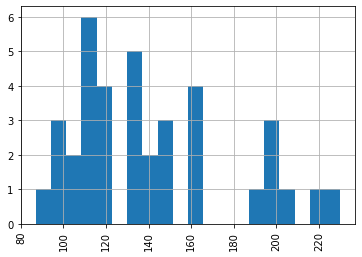

In [245]:
sensor_ids.living_space_m2.hist(xrot=90, bins=20)
#plt.xticks(rotation=90)
#plt.show()

<AxesSubplot:>

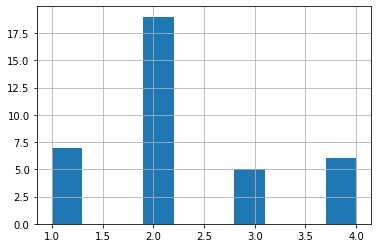

In [243]:
sensor_ids.n_inhabitants.hist()

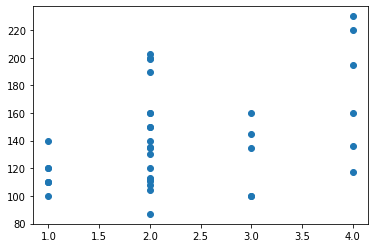

In [201]:
plt.scatter(sensor_ids.n_inhabitants, sensor_ids.living_space_m2)

In [204]:
sensor_ids.pv.sum()/len(sensor_ids)

0.10810810810810811

In [5]:
pv_households = set(sensor_ids[sensor_ids.pv == True].id)
pv_households

{'sfh13', 'sfh15', 'sfh26', 'sfh33'}

In [6]:
data.id.unique()

array(['sfh10', 'sfh11', 'sfh12', 'sfh13', 'sfh14', 'sfh15', 'sfh16',
       'sfh17', 'sfh18', 'sfh19', 'sfh20', 'sfh21', 'sfh22', 'sfh23',
       'sfh24', 'sfh25', 'sfh26', 'sfh27', 'sfh28', 'sfh29', 'sfh3',
       'sfh30', 'sfh31', 'sfh32', 'sfh33', 'sfh34', 'sfh35', 'sfh36',
       'sfh37', 'sfh38', 'sfh39', 'sfh4', 'sfh40', 'sfh5', 'sfh6', 'sfh7',
       'sfh8', 'sfh9'], dtype=object)

In [7]:
data.id.isin(pv_households).sum()

11524

Ideas for power profiles:
- One profile for 1 person, 2 person, 3 persons, 4 persons
- One for <=120m^2, 120-160m^2, >160m^2 (i.e., 190-230)
- One for PV

In [236]:
data

,time,w,id
0,2019-01-01 00:00:00,675.809998,sfh10
1,2019-01-01 00:15:00,675.809998,sfh10
2,2019-01-01 00:30:00,675.809998,sfh10
3,2019-01-01 00:45:00,675.809998,sfh10
4,2019-01-01 01:00:00,638.450557,sfh10
...,...,...,...
106596,2019-01-30 23:00:00,824.773335,sfh9
106597,2019-01-30 23:15:00,318.395555,sfh9
106598,2019-01-30 23:30:00,634.065117,sfh9
106599,2019-01-30 23:45:00,1434.386327,sfh9


In [246]:
data.max()

time    2019-01-31 00:00:00
w               6339.414345
id                     sfh9
dtype: object

In [19]:
%matplotlib inline

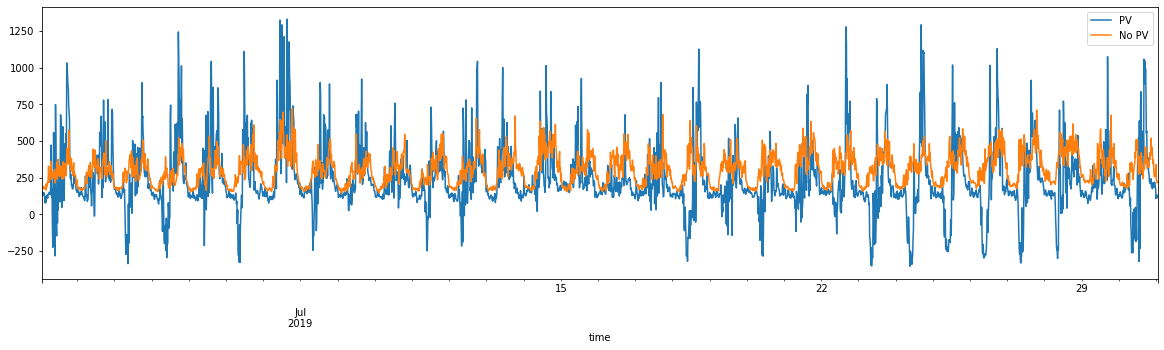

In [59]:
ts[pv_households].mean(axis=1).plot(label="PV", figsize=(20,5))
ts[set(data.id.unique())-pv_households].mean(axis=1).plot(label="No PV")
plt.legend()

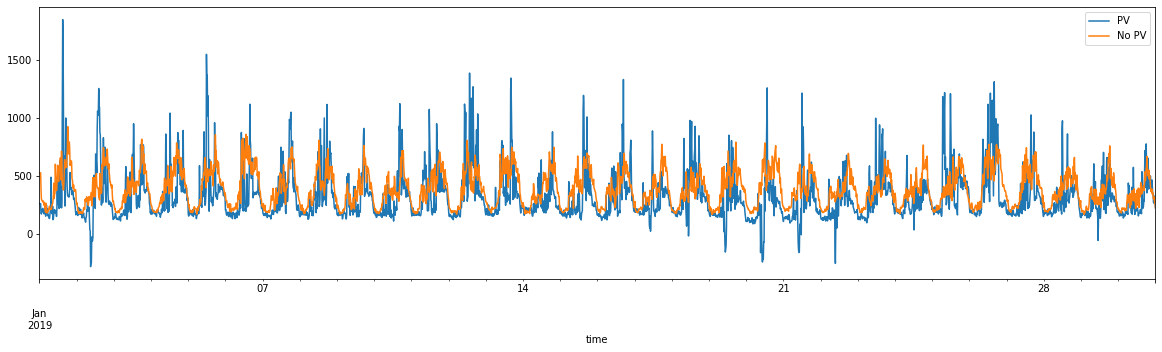

In [48]:
ts[pv_households].mean(axis=1).plot(label="PV", figsize=(20,5))
ts[set(data.id.unique())-pv_households].mean(axis=1).plot(label="No PV")
plt.legend()

In [53]:
pv_households

{'sfh13', 'sfh15', 'sfh26', 'sfh33'}

In [58]:
data[data["w"]<0].id.unique()

array(['sfh13', 'sfh15', 'sfh33'], dtype=object)

<AxesSubplot:xlabel='time'>

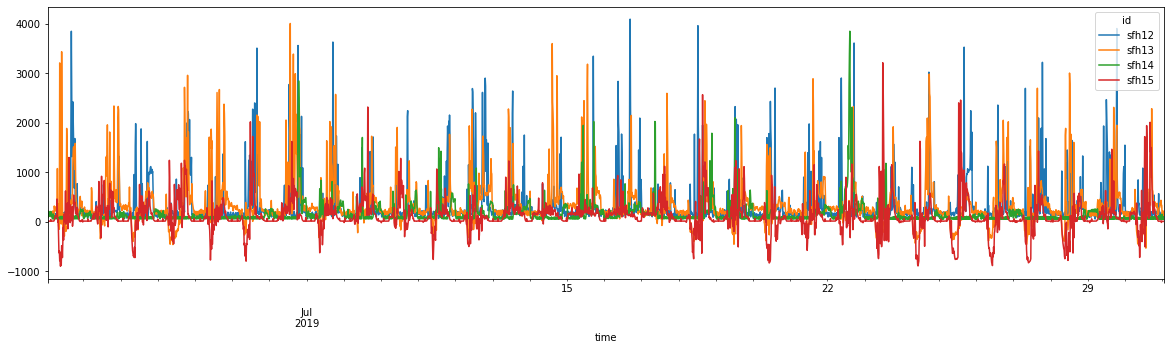

In [61]:
ts = data.pivot(index="time", columns="id", values="w")
ts[[f"sfh{i}" for i in range(12,16)]].plot(figsize=(20,5))

In [17]:
# FIXME: Is this some error in the DB?. Is data loaded in local time (i.e. will the results be different during winter/summer?)
start_date = '2019-07-01 00:00:00+02'
split_date = '2019-07-04 00:00:00'
end_date   = '2019-07-05 00:00:00+02'

if True:
    start_date = '2019-01-01 00:00:00+02'
    split_date = '2020-01-01 00:00:00'
    end_date   = '2020-01-03 00:00:00+02'
print(np.datetime64(split_date))
wpuq = PowerDataModule(dataset="wpuq", start_date=start_date, end_date=end_date, split_date=split_date, load_metadata=True)
wpuq.setup()

print(wpuq.data.index.min())
print(wpuq.data.index.max())
wpuq.metadata.head()

2020-01-01T00:00:00
                       time           w     id
0       2018-12-31 23:00:00  588.476000  sfh10
1       2018-12-31 23:15:00  607.279223  sfh10
2       2018-12-31 23:30:00  586.129446  sfh10
3       2018-12-31 23:45:00  562.455109  sfh10
4       2019-01-01 00:00:00  675.809998  sfh10
...                     ...         ...    ...
1303291 2020-01-02 22:00:00  645.542221   sfh9
1303292 2020-01-02 22:15:00  530.379112   sfh9
1303293 2020-01-02 22:30:00  154.658555   sfh9
1303294 2020-01-02 22:45:00  117.672555   sfh9
1303295 2020-01-02 23:00:00  136.470001   sfh9

[1303296 rows x 3 columns]


/home/bschaefermeier/.local/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/bschaefermeier/.local/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


SELECT id, n_inhabitants, living_space_m2, pv
FROM wpuq_meta
2018-12-31 23:00:00
2020-01-02 23:00:00


,id,n_inhabitants,living_space_m2,pv
0,sfh10,3.0,135.0,False
1,sfh11,4.0,230.0,False
2,sfh12,2.0,112.0,False
3,sfh14,2.0,150.0,False
4,sfh16,4.0,136.0,False


In [111]:
# Sanity check.
len(wpuq.data_train)+len(wpuq.data_val) == 35*3

True

In [ ]:
wpuq

In [105]:
# FIXME: Is this some error in the DB?. Is data loaded in local time (i.e. will the results be different during winter/summer?)
start_date = '2021-07-01 00:00:00+02'
split_date = '2021-07-04 00:00:00'
end_date   = '2021-07-05 00:00:00+02'

snh = PowerDataModule(dataset="snh", start_date=start_date, end_date=end_date, split_date=split_date, load_metadata=False)
snh.setup()
snh.data

/home/bschaefermeier/.local/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/bschaefermeier/.local/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


id,1,2,3,4,5,6,7,8,9,10,...,374,375,376,377,378,379,380,381,383,384
time,,,,,,,,,,,,,,,,,,,,,
2021-07-01 00:00:00,0.003205,0.004032,0.037441,0.000000,0.0,0.051392,NaN,NaN,0.065954,0.073286,...,0.000000,0.023720,0.113006,NaN,0.012658,0.010039,0.021512,0.000000,0.184211,NaN
2021-07-01 00:15:00,0.012821,0.020161,0.099844,0.000000,0.0,0.029979,NaN,NaN,0.010695,0.111111,...,0.078740,0.024969,0.187633,NaN,0.005754,0.012355,0.017442,0.060498,0.115385,NaN
2021-07-01 00:30:00,0.001603,0.141129,0.068643,0.015355,0.0,0.006424,NaN,NaN,0.010695,0.087470,...,0.000000,0.014981,0.093817,NaN,0.026467,0.023166,0.018023,0.000000,0.105263,NaN
2021-07-01 00:45:00,0.001603,0.012097,0.029641,0.000000,0.0,0.004283,NaN,NaN,0.010695,0.231678,...,0.001969,0.016230,0.091684,NaN,0.024166,0.029344,0.049419,0.000000,0.089069,NaN
2021-07-01 01:00:00,0.012821,0.012097,0.207488,0.090211,0.0,0.004283,NaN,NaN,0.010695,0.073286,...,0.013780,0.007491,0.149254,NaN,0.041427,0.002317,0.029651,0.000000,0.078947,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-04 23:00:00,0.014423,0.024194,0.081123,0.000000,0.0,0.077088,NaN,NaN,0.033868,0.002364,...,0.061024,0.047441,0.021322,NaN,0.011507,0.033977,0.032558,0.000000,0.238866,NaN
2021-07-04 23:15:00,0.011218,0.024194,0.071763,0.000000,0.0,0.079229,NaN,NaN,0.023173,0.018913,...,0.076772,0.071161,0.017058,NaN,0.001151,0.007722,0.048837,0.000000,0.145749,NaN
2021-07-04 23:30:00,0.059295,0.000000,0.168487,0.003839,0.0,0.042827,NaN,NaN,0.000000,0.047281,...,0.183071,0.018727,0.072495,NaN,0.048331,0.012355,0.061628,0.000000,0.149798,NaN


In [ ]:
# FIXME: Is this some error in the DB?. Is data loaded in local time (i.e. will the results be different during winter/summer?)
start_date = '2011-11-30T01:00:00Z'
split_date = '2011-12-03 00:00:00'
end_date   = '2011-12-04T01:00:00Z'

lsm = PowerDataModule(dataset="lsm", start_date=start_date, end_date=end_date, split_date=split_date, load_metadata=False)
lsm.setup()
lsm.data

In [177]:
x = torch.tensor(wpuq.data_test)

/share/apps/anaconda/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [179]:
x = wpuq.data_train.clone().detach()

AttributeError: 'Subset' object has no attribute 'clone'

In [174]:
torch.tensor(wpuq.data_train)

ValueError: only one element tensors can be converted to Python scalars

In [170]:
print(len(wpuq.train_dataloader())*64/35)
print(len(wpuq.val_dataloader())*64/35)

325.48571428571427
36.57142857142857


In [ ]:
for dl in [wpuq.train_dataloader(), wpuq.val_dataloader(), wpuq.test_dataloader()]:
    print("====")
    for batch in dl:
        print(batch.shape)

In [ ]:
wpuq.data_train[0]

In [197]:
dl = wpuq.train_dataloader()

In [198]:
dl